In [94]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
import os
from os.path import join
import xarray as xr
import pandas as pd

import time
import copy 
import datetime

import sys  
sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.preprocessing import preprocess

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

vol = '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/'
# vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
xar = xr.open_dataset(vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

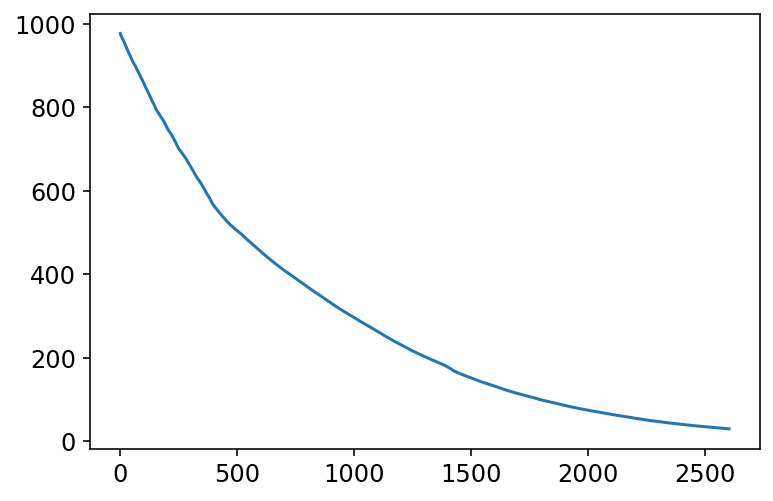

In [6]:
plt.plot(p);

In [17]:
from scipy import interpolate

def interpolate_profile(y, sonde_profile_dims=4000):
    f = interpolate.interp1d(np.arange(len(y)), y, kind='linear')
    return f(np.linspace(0, len(y) - 1, sonde_profile_dims))

pi = interpolate_profile(p)
ti = interpolate_profile(t)

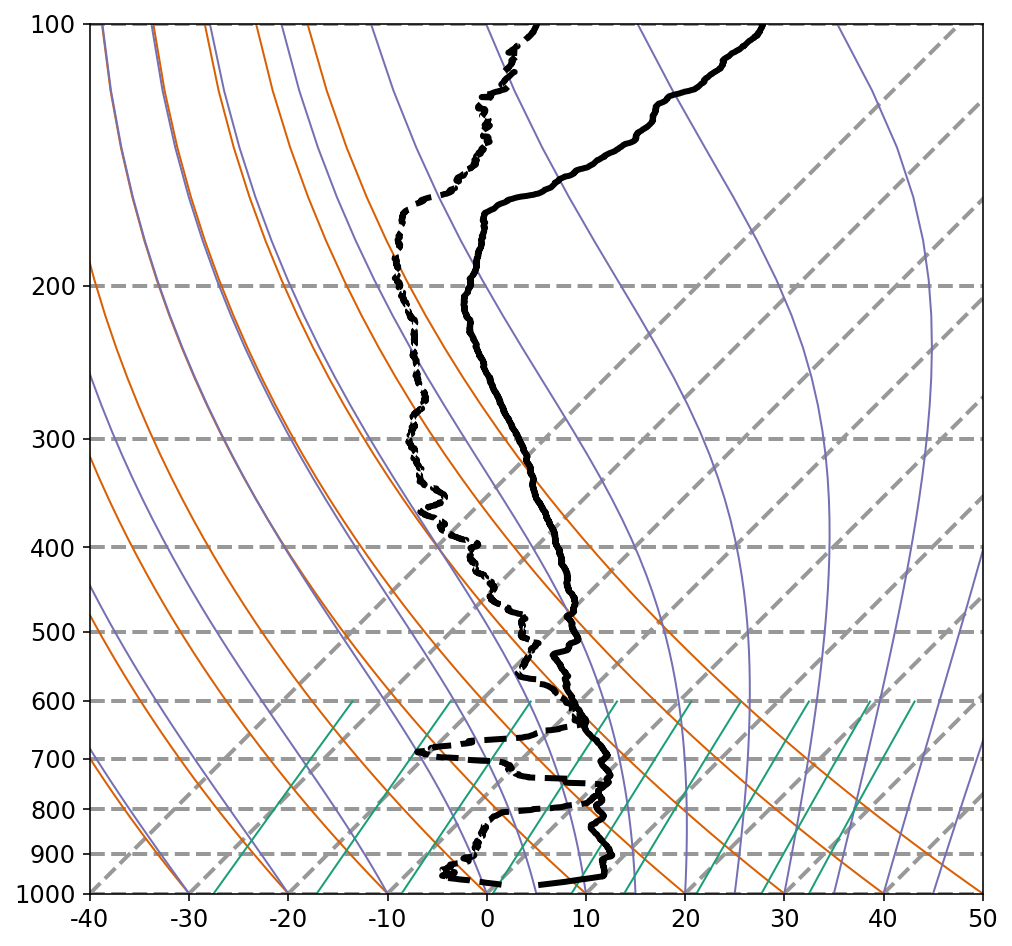

In [3]:
sounding_dict_for_metpy = dict()

sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = p
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = t
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = td

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy)
plt.show()

In [3]:
SONDE_PROFILE_DIMS = 2000
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= (SONDE_PROFILE_DIMS / 2) and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

def plot_results(nnet, X, T, index=0, loss=True):
    
    sounding_dict_for_metpy = dict()

    if len(X.shape) > 2:
        P = X[index,:,PRESSURE]
    else:
        # (n, p_dim + t_dim + td_dim)
        P = X[index,:SONDE_PROFILE_DIMS]

    sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = P
    sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = T[index,:]
    sounding_dict_for_metpy[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(X[index:index+1,:])[0]
    
    radiosonde_plotting.plot_predicted_sounding(sounding_dict_for_metpy)
    if loss:
        fig, ax = plt.subplots(1, figsize=(8, 4))

        ax.plot(nnet.history['loss'], label='train')
        ax.plot(nnet.history['val_loss'], label='val')
        ax.legend();
    
def mean_pressure_errors(nnet, X, T):
    error = np.abs((nnet.use(X) - T))
    pressures = Xtest[:,:,PRESSURE]
    # Create linearly spaced bins from the min to max pressure
    bins = np.linspace(pressures.min(), pressures.max(), pressures.shape[1])
    # Indicies of where which bin pressure values belong
    pressure_bin_indicies = np.digitize(pressures, bins)
    pressure_bin_indicies
    
    mean_error = np.zeros(bins.size)
    # Mean error corresponding to each bin of pressure levels
    for bin_index in range(bins.size):
        vals = error[pressure_bin_indicies == bin_index]
        mean = np.mean(vals) if vals.size > 0 else 0
        mean_error[bin_index] = mean
        
    # trim mean 0's from ends
    s = 0
    for i in range(mean_error.size):
        if mean_error[i] != 0:
            s = i
            break
    e = mean_error.size
    for i in range(mean_error.size-1, 0, -1):
        if mean_error[i] != 0:
            e = i
            break

    mean_error = mean_error[s:e+1]
    bins = bins[s:e+1]
    
    return mean_error, bins

time: 26.320, avg: 0.025 seconds
2001: 874/1037 are valid


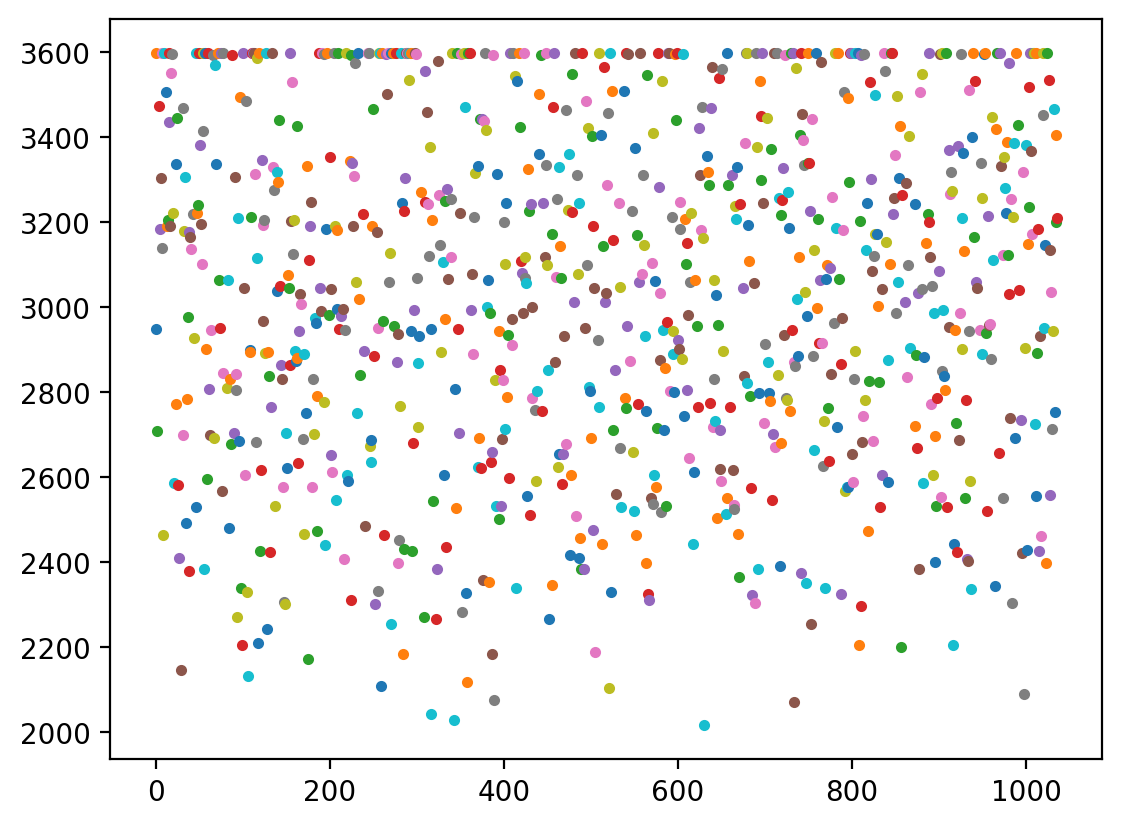

In [10]:
for year in range(2001, 2002): # 2021
    files = np.array(glob(join(vol, str(year), f'sgpsondewnpnC1.b1.*.cdf')))
    is_valid = np.ones(files.size, dtype=bool)
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        if valid_raob(xar):
            plt.plot(i, xar.pres.values.size, '.')
        else:
            is_valid[i] = False
        xar.close()
    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
    print(f'{year}: {np.where(is_valid == True)[0].size}/{files.size} are valid')

In [29]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

# Samples, (Pressure, Temperature, Dewpoint), Pressure Dims
profiles = np.zeros((files.size, 3, SONDE_PROFILE_DIMS))
is_valid = np.ones(files.size, dtype=bool)

fp = FloatProgress(min=0, max=(len(files)))
display(fp)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        p = preprocess.interpolate_profile(xar.pres.values, SONDE_PROFILE_DIMS)
        t = preprocess.interpolate_profile(xar.tdry.values, SONDE_PROFILE_DIMS)
        td = preprocess.interpolate_profile(xar.dp.values, SONDE_PROFILE_DIMS)
        profiles[i] = np.concatenate(([p], [t], [td]))
    else:
        is_valid[i] = False        
    xar.close()    
    fp.value += 1
e = time.time() - s

profiles = profiles[np.where(is_valid)[0]]

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
print(f': {np.where(is_valid == True)[0].size}/{files.size} are valid')

FloatProgress(value=0.0, max=27209.0)

time: 692.739, avg: 0.025 seconds
: 24589/27209 are valid


In [31]:
# np.save('/s/chopin/l/grad/stock/data/soundings/raobs/profiles-4000.npy', profiles)

In [4]:
profiles = np.load(vol + '../profiles.npy')

In [5]:
profiles.shape

(24589, 3, 2000)

## Set GPU (Incompatible on CS)

In [34]:
gpus = tf.config.list_physical_devices('XLA_GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'XLA_GPU')
        logical_gpus = tf.config.list_logical_devices('XLA_GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 0 Logical GPU


In [35]:
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [36]:
!nvidia-smi

Tue Jul 14 12:26:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   33C    P8    14W / 250W |     62MiB / 12212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Fully Connected NN

In [19]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, input_dims, :]
Xtrain = Xtrain.reshape((-1, Xtrain[0,:].size))
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = Xtest[:, input_dims, :]
Xtest = Xtest.reshape((-1, Xtest[0,:].size))
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 6000), (19671, 2000), (4918, 6000), (4918, 2000))

In [28]:
# 176 s
nnet = nn.NeuralNetwork(Xtrain.shape[1], [512, 256, 128, 256, 512], Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 25, 64, method='adam', verbose=True, 
           learning_rate=0.005, validation=[Xtest, Ttest])

epoch: 0, loss: 0.21868
epoch: 5, loss: 0.08301
epoch: 10, loss: 0.07301
epoch: 15, loss: 0.06841
epoch: 20, loss: 0.06474
epoch: 24, loss: 0.06029
finished!


NeuralNetwork(6000, [512, 256, 128, 256, 512], 2000)
  Final objective value is 0.06029 in 117.1774 seconds.

In [56]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024 

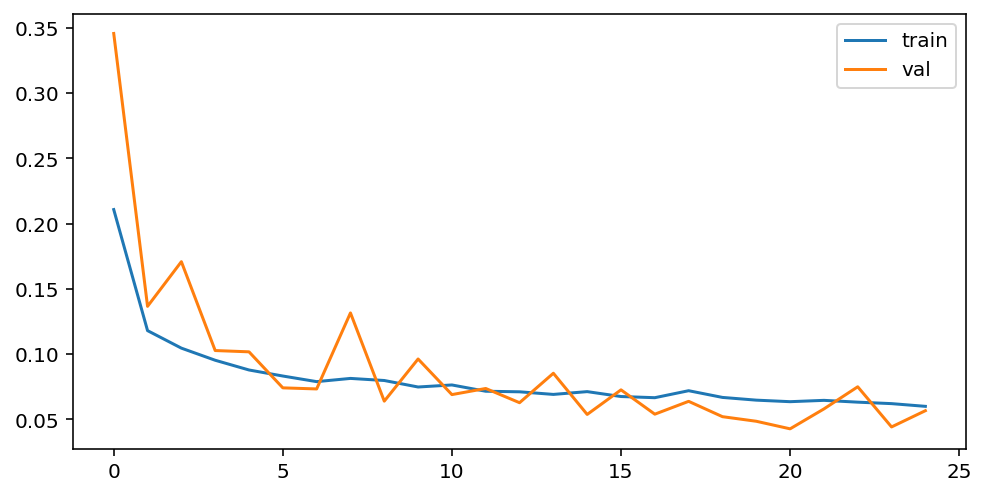

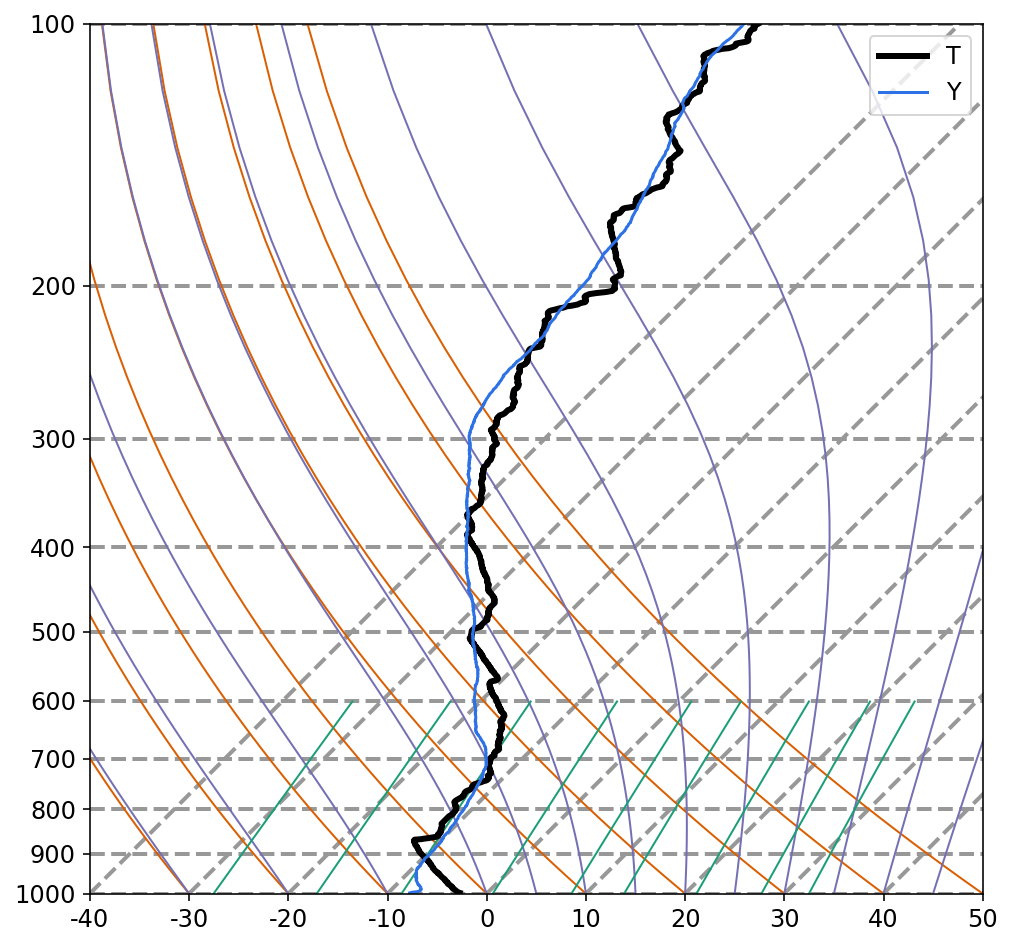

In [71]:
plot_results(nnet, Xtest, Ttest, index=0)

## Convolutional NN

In [333]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [370]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(10, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 15, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.19767
epoch: 5, loss: 0.01266
epoch: 10, loss: 0.00833
epoch: 14, loss: 0.00654
finished!


ConvolutionalNeuralNetwork((2000, 3), [3, 3, 3, 3], [(10, 1), (10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00654 in 91.6030 seconds.

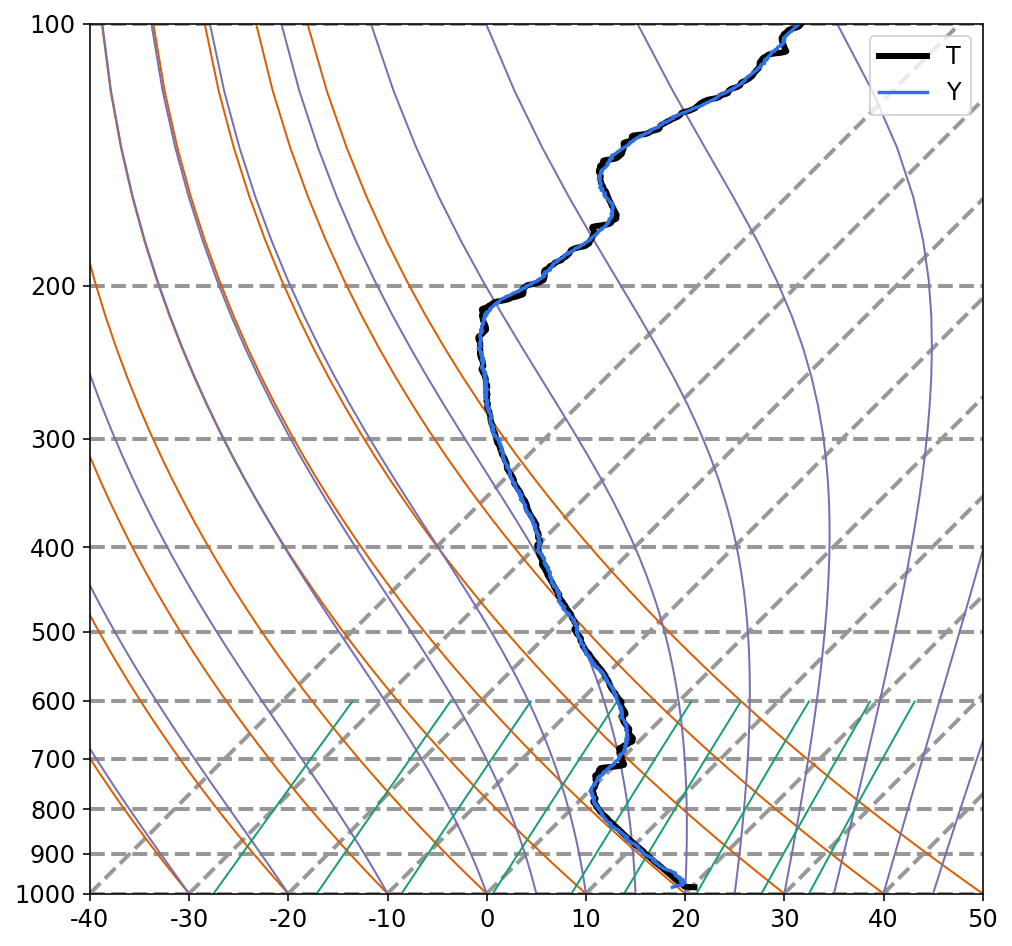

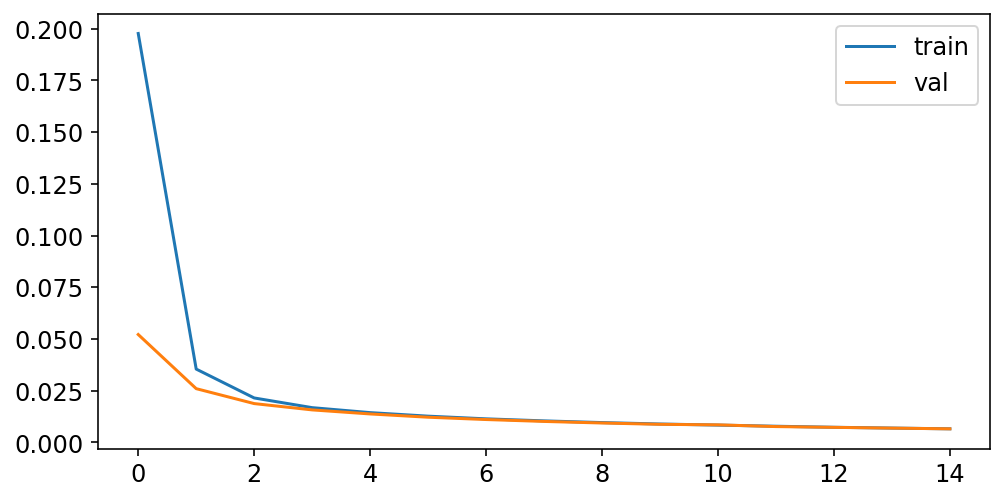

In [371]:
plot_results(nnet, Xtest, Ttest, index=22, loss=True)

In [372]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)

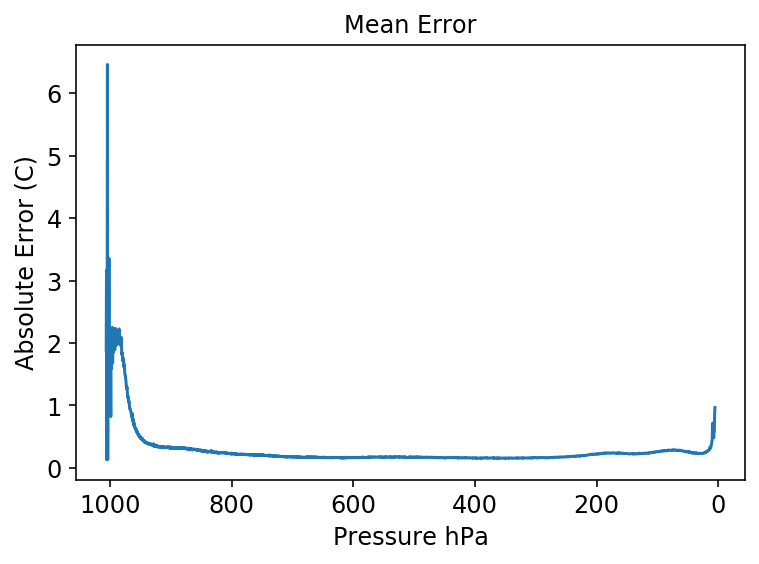

In [373]:
plt.plot(bins, mean_error)
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

FloatProgress(value=0.0, max=12.0)

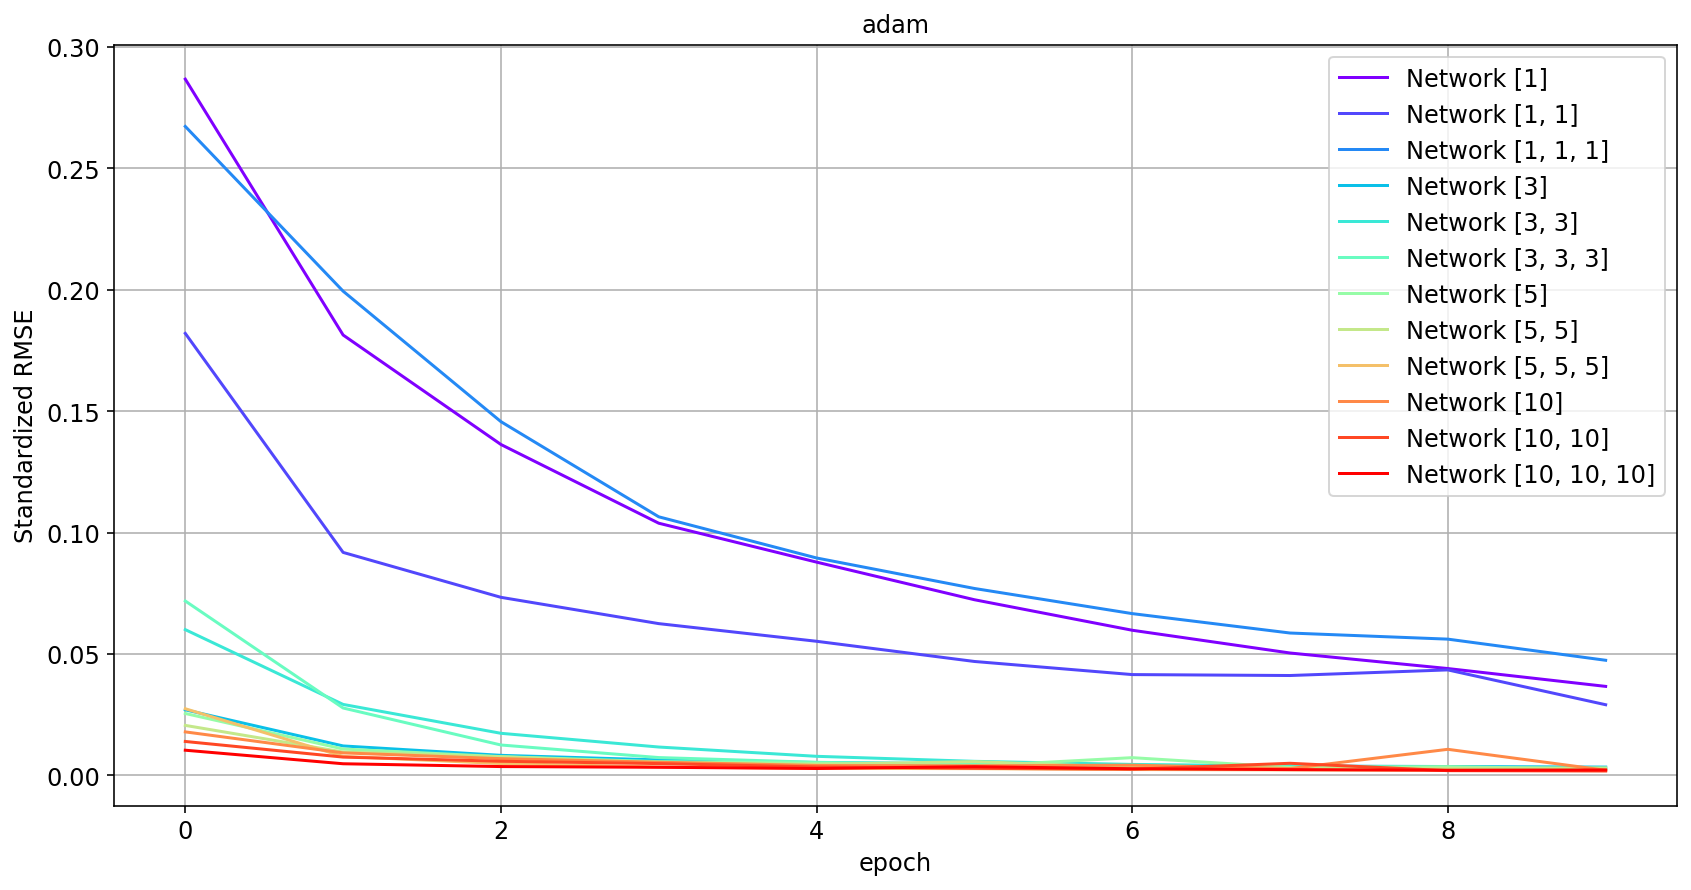

In [48]:
epochs = 10
batch_size = 128 #, 64
rho = 0.001
activation = 'relu'
depth = 3
units = [[nu] * nl for nu in [1, 3, 5, 10] for nl in range(1, depth + 1)] # 
ker_str = [[nu] * nl for nu in [(10, 1)] for nl in range(1, depth + 1)] # , (20, 1)
trials = len(units)

methods = ['adam']

f = FloatProgress(min=0, max=(trials * len(methods)))
display(f)

fig, axs = plt.subplots(len(methods), 1, figsize=(14, 7 * len(methods)))
for m, method in enumerate(methods):
    loss = []
    ax = axs if len(methods) == 1 else axs[m]
    for i in range(trials):
        n_units_in_conv_layers = units[i]
        
        kernels_size_and_stride = ker_str[len(n_units_in_conv_layers)-1]
        
        nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], n_units_in_conv_layers, 
                                             kernels_size_and_stride,
                                             Ttrain.shape[1], activation=activation)
        nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method, verbose=False, 
                   learning_rate=rho, validation=[Xtest, Ttest])
        
        loss.append(nnet.history['val_loss'])
        f.value += 1
    
    color=iter(plt.cm.rainbow(np.linspace(0,1,trials)))

    for j, err in enumerate(loss):
        ax.plot(err, c=next(color), label='Network '+str(units[j]))

    ax.set_title(method)
    ax.set_xlabel('epoch'), plt.ylabel('Standardized RMSE')
    ax.legend(); ax.grid(True);

plt.show()

In [56]:
# min rmse
np.min(nnet.history['val_loss'])

0.0020879118237644434

In [19]:
tf.keras.losses.MSE(Ttest[0:1,:], nnet.use(Xtest[0:1,:]))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([20.68639338])>

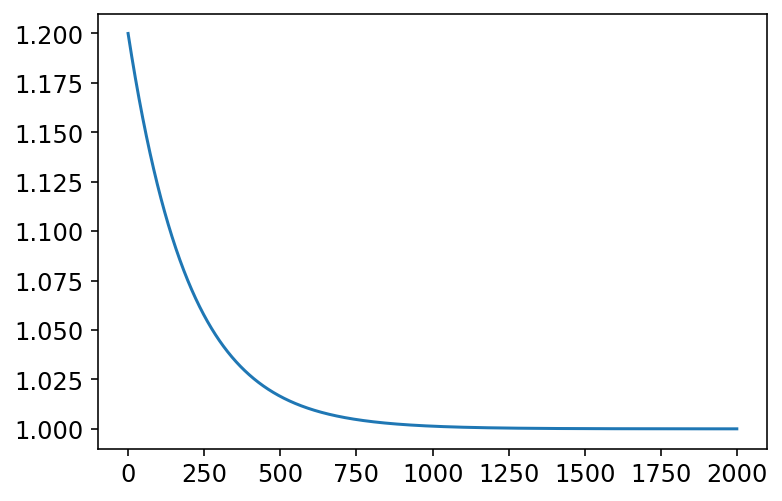

In [98]:
# exponential decay

plt.plot(y(x))

In [20]:
%timeit weighted_mean_squared_error(Ttest[0:1,:], nnet.use(Xtest[0:1,:]))

16.8 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
np.square(np.log(Ttest[0:1,:] + 1) - np.log(nnet.use(Xtest[0:1,:]) + 1))

In [54]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 10)          310       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 10)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 10)          1010      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 10)           1010      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 10)           0     

## Convolutional AutoEncoder

In [145]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [147]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [3, 3, 3], [(10, 1)]*3,
                                     Ttrain.shape[1], activation='relu')
# nnet.model.summary()
nnet.train(Xtrain, Ttrain, 10, 64, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.25888
epoch: 5, loss: 0.01078
epoch: 9, loss: 0.00780
finished!


ConvolutionalAutoEncoder((2000, 3), [3, 3, 3], [(10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00780 in 188.3591 seconds.

In [148]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 3)           93        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 3)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 3)           93        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 3)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 3)            93        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 3)            0     

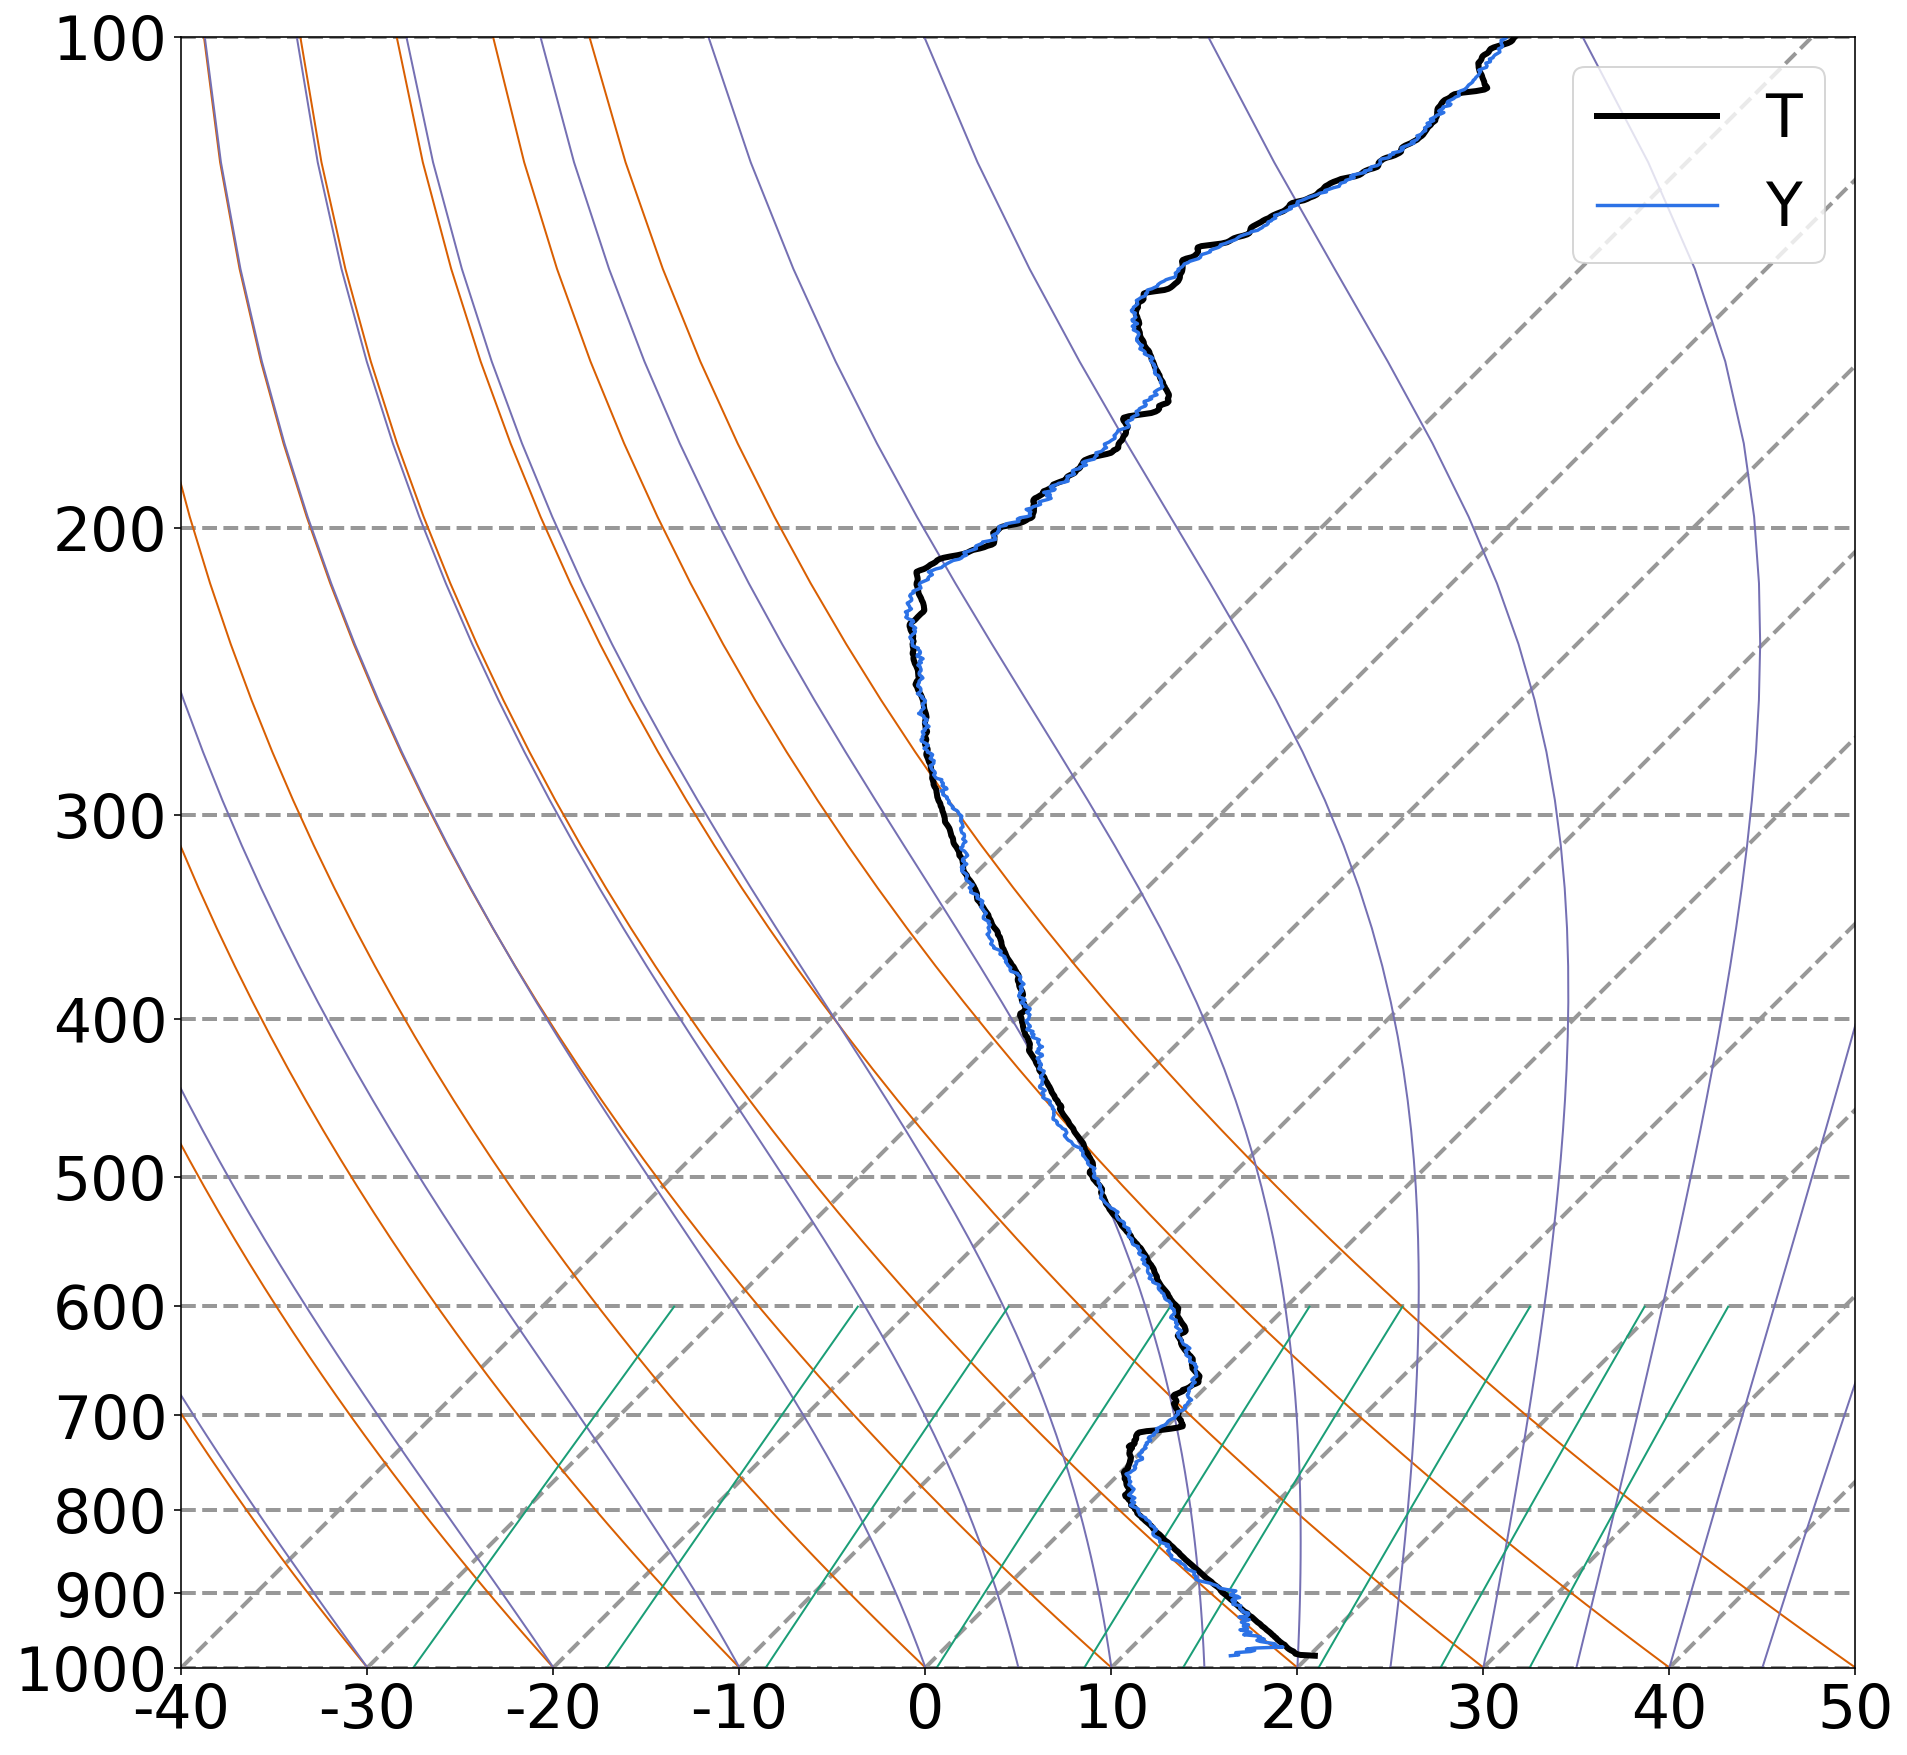

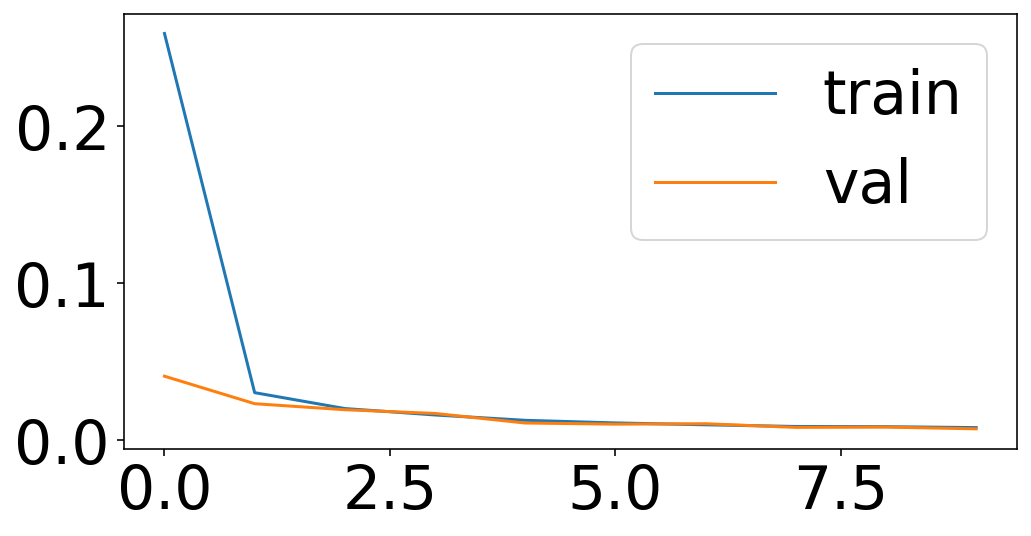

In [152]:
plot_results(nnet, Xtest, Ttest, index=22)

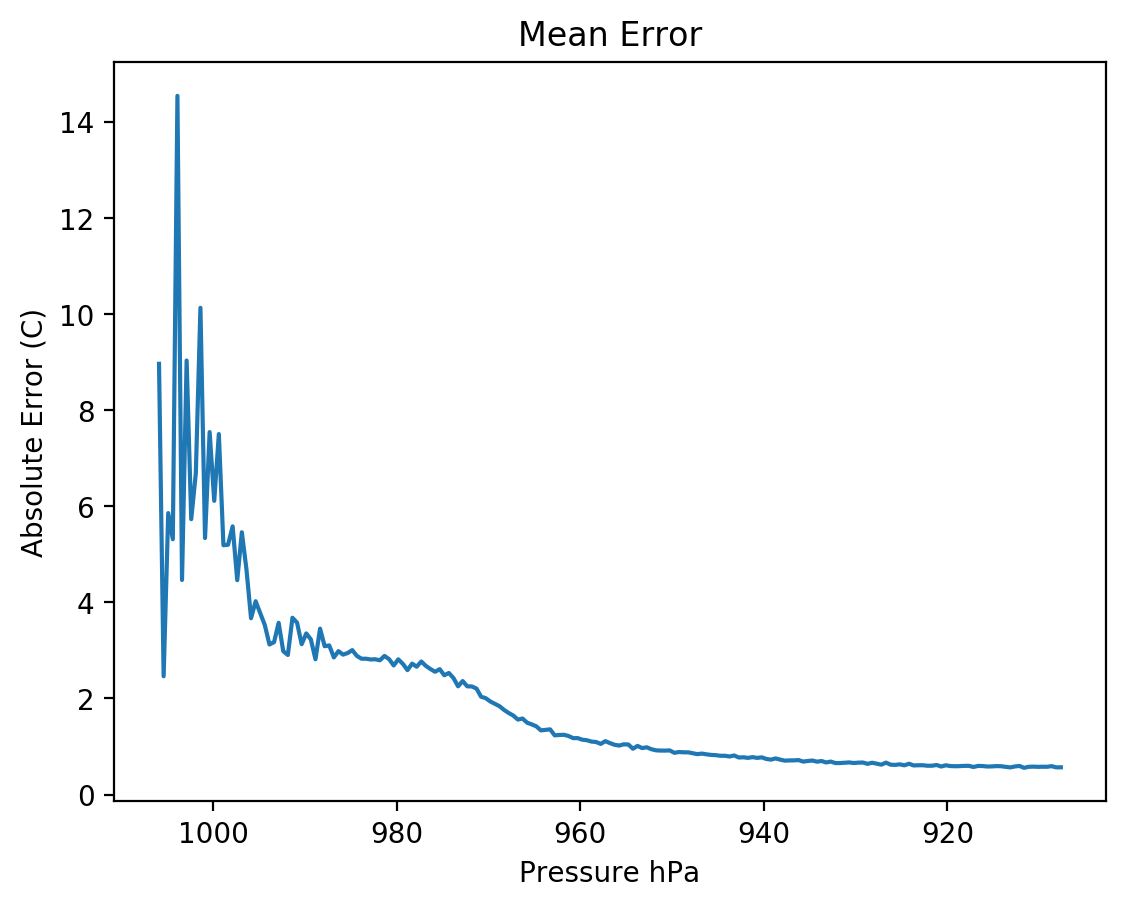

In [155]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)
plt.rcdefaults()
plt.plot(bins[1800:], mean_error[1800:])
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

## Operational

In [77]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      profiles:  1.1 GiB
                         files: 10.9 MiB
                      is_valid: 26.7 KiB
                 FloatProgress:  1.0 KiB
                           _i8:  926.0 B
                          _i24:  815.0 B
                          _i27:  810.0 B
                          _i29:  807.0 B
                          _i30:  807.0 B
                          _i32:  798.0 B


## Density

In [142]:
files = np.array(glob(join(vol, '2001/sgpsondewnpnC1.b1.*.cdf')))

pressures = np.array([])

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        pressures = np.append(pressures, xar.pres.values)    
    xar.close()    
e = time.time() - s

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

time: 11.227, avg: 0.011 seconds


In [143]:
pressures.shape

(2647636,)

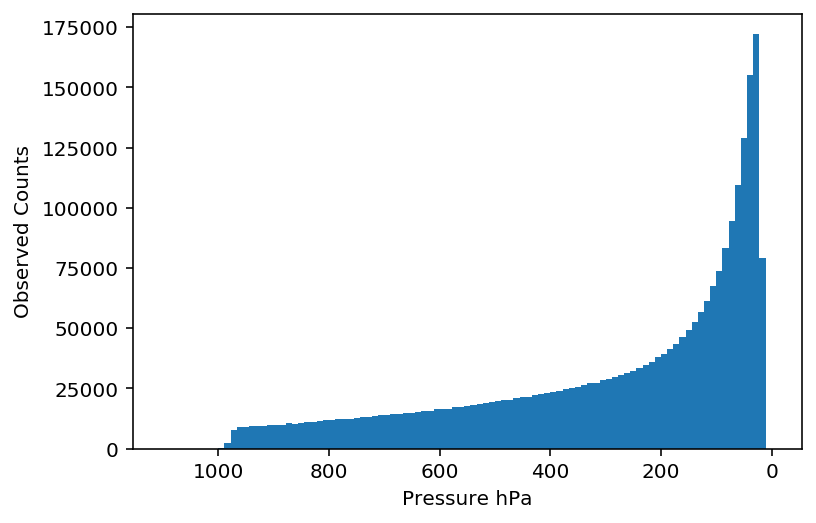

In [154]:
plt.hist(pressures, bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');

In [161]:
Xtrain[:,:,PRESSURE].ravel().shape

(39342000,)

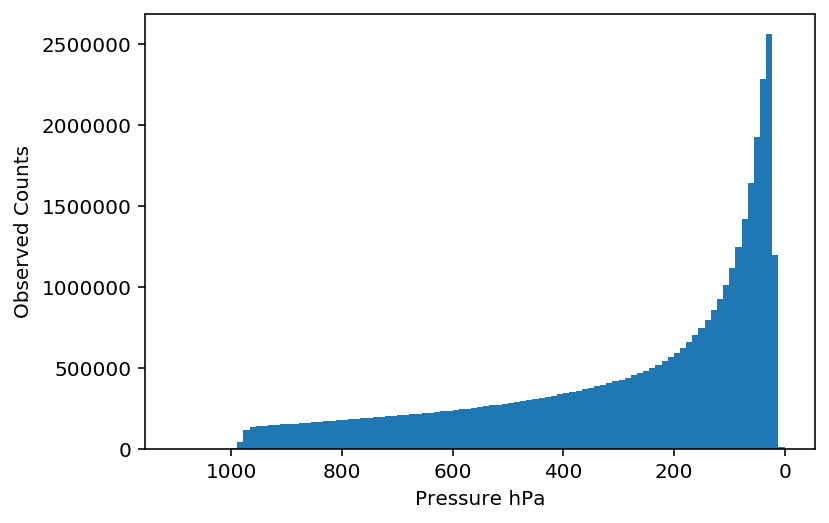

In [160]:
plt.hist(Xtrain[:,:,PRESSURE].ravel(), bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');

## Improved Surface Predictions

1. Interpolate high pressure values - increase precision at lower altitudes
2. Apply more weight to high pressure values - modify loss function
3. Ground surface level measurements - include RTMA data to improve on surface RAOB data
4. Evaluate models that are trained at different levels - can the surface be modeled correctly without interference of higher altitudes 

### 1. Intropolation

In [ ]:
surface = int(round(np.mean(np.argmin(np.abs(Xtrain[:, :, PRESSURE] - 900), axis=1))))
SURFACE_IN_DIMS = 500

Xptrain = np.zeros((Xtrain.shape[0], Xtrain.shape[1] - surface + SURFACE_IN_DIMS, len(input_dims)))
for i in range(Xtrain.shape[0]):
    for dim in input_dims:
        Xptrain[i, :SURFACE_IN_DIMS, dim] = preprocess.interpolate_profile(
            Xtrain[i, :surface, dim], SURFACE_IN_DIMS)
        Xptrain[i, SURFACE_IN_DIMS:, dim] = Xtrain[i, surface:, dim]
        
Xptest = np.zeros((Xtest.shape[0], Xtest.shape[1] - surface + SURFACE_IN_DIMS, len(input_dims)))
for i in range(Xtest.shape[0]):
    for dim in input_dims:
        Xptest[i, :SURFACE_IN_DIMS, dim] = preprocess.interpolate_profile(
            Xtest[i, :surface, dim], SURFACE_IN_DIMS)
        Xptest[i, SURFACE_IN_DIMS:, dim] = Xtest[i, surface:, dim]

$\sigma = (p - p_T)/(p_S - p_T)$ where p is pressure, and the subscripts T and S stand for the top and the ground surface values of the model atmosphere, respectively.

$(p_S - p_T)\sigma + p_T = p$

In [275]:
xar = xr.open_dataset(vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

In [256]:
sigma = (p - p[-1])/(p[0] - p[-1])

In [258]:
ps = (p[0] - p[-1])*sigma + p[-1]

In [276]:

# if p[-1] > min_p:
#     p = np.append(p, min_p)
#     t = np.append(t, t[-1])
#     td = np.append(td, td[-1])
# print(p)

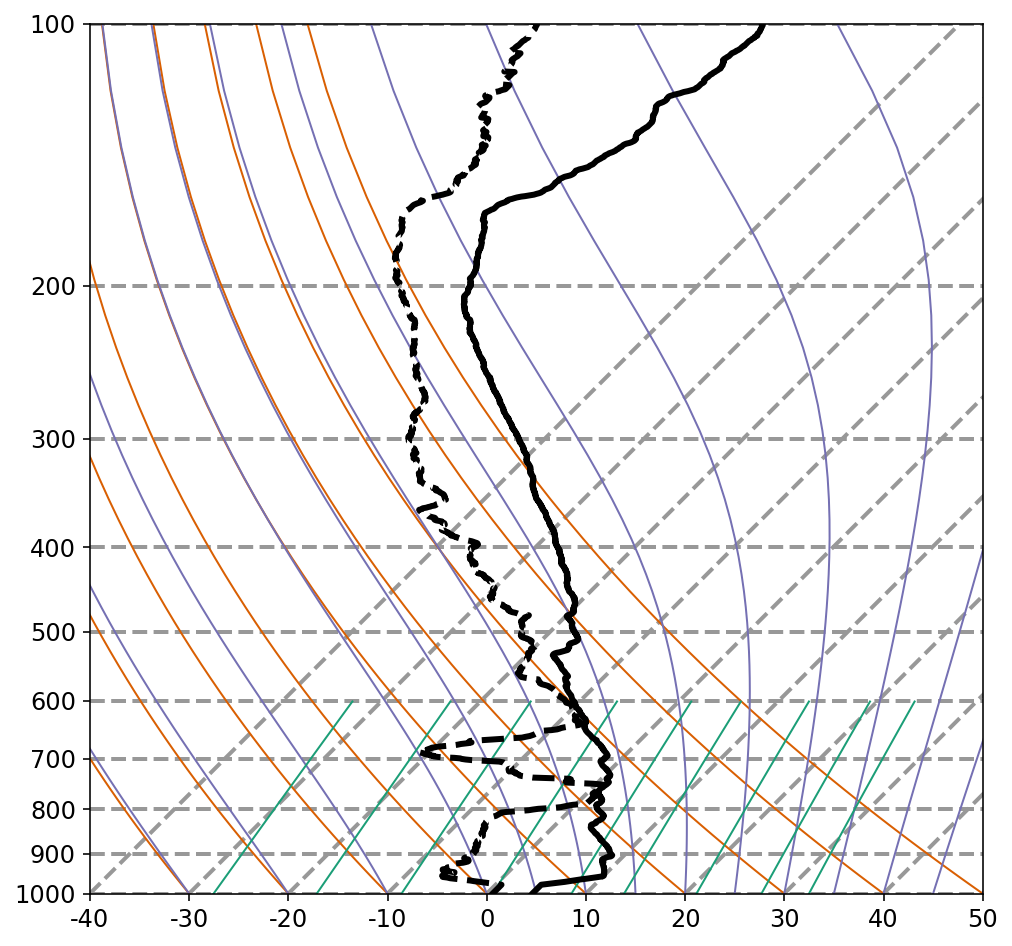

In [277]:
p = preprocess.interpolate_profile(p, SONDE_PROFILE_DIMS)
t = preprocess.interpolate_profile(t, SONDE_PROFILE_DIMS)
td = preprocess.interpolate_profile(td, SONDE_PROFILE_DIMS)

sounding_dict_for_metpy = dict()

sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = p
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = t
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = td

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy)
plt.show()

In [297]:
files = np.array(glob(join(vol, '200*/sgpsondewnpnC1.b1.*.cdf')))

# Samples, (Pressure, Temperature, Dewpoint), Pressure Dims
profiles = np.zeros((files.size, 3, SONDE_PROFILE_DIMS))
is_valid = np.ones(files.size, dtype=bool)

fp = FloatProgress(min=0, max=(len(files)))
display(fp)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        min_p = 5.1
        max_p = 1012.5
        p = xar.pres.values
        t = xar.tdry.values
        td = xar.dp.values
        if p[0] < max_p:
            distance = int(round(np.abs(p[0] - max_p)))
            p = np.insert(p, 0, preprocess.interpolate_profile([max_p, p[0]], distance))
            t = np.insert(t, 0, preprocess.interpolate_profile([t[0], t[0]], distance))
            td = np.insert(td, 0, preprocess.interpolate_profile([td[0], td[0]], distance)) 
        p = preprocess.interpolate_profile(p, SONDE_PROFILE_DIMS)
        t = preprocess.interpolate_profile(t, SONDE_PROFILE_DIMS)
        td = preprocess.interpolate_profile(td, SONDE_PROFILE_DIMS)
        profiles[i] = np.concatenate(([p], [t], [td]))
    else:
        is_valid[i] = False        
    xar.close()    
    fp.value += 1
e = time.time() - s

profiles = profiles[np.where(is_valid)[0]]

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
print(f': {np.where(is_valid == True)[0].size}/{files.size} are valid')

FloatProgress(value=0.0, max=12379.0)

time: 230.724, avg: 0.019 seconds
: 11684/12379 are valid


In [203]:
print(profiles[:, PRESSURE].min(), profiles[:, PRESSURE].max())
print(profiles[:, TEMPERATURE].min(), profiles[:, TEMPERATURE].max())

5.099999904632568 1012.4000244140625
-81.26276332059462 44.09000015258789


In [298]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]

In [316]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(3, 1)]*4,
                                     Ttrain.shape[1], activation='relu')

nnet.train(Xtrain, Ttrain, 20, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.51773
epoch: 5, loss: 0.05922
epoch: 10, loss: 0.02513
epoch: 15, loss: 0.01314
epoch: 19, loss: 0.00936
finished!


ConvolutionalNeuralNetwork((2000, 3), [3, 3, 3, 3], [(3, 1), (3, 1), (3, 1), (3, 1)], 2000)
  Final objective value is 0.00936 in 43.7464 seconds.

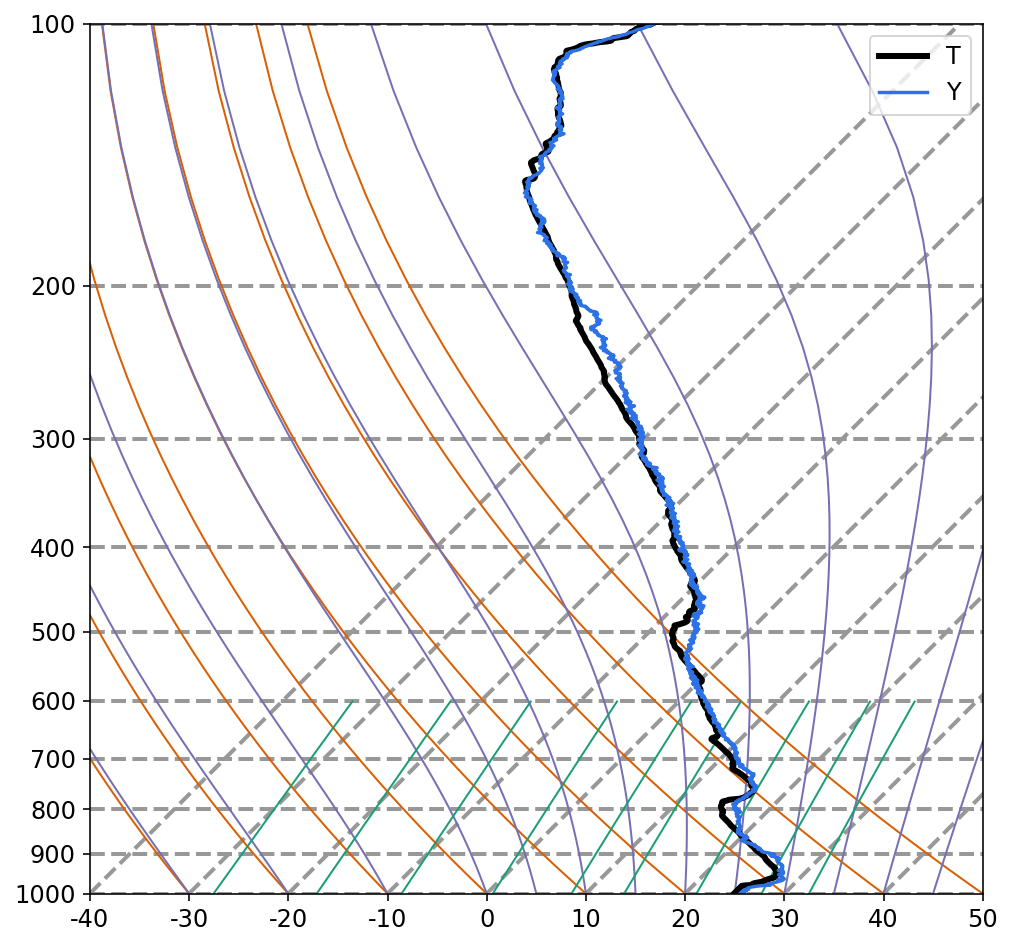

In [326]:
plot_results(nnet, Xtest, Ttest, 16, loss=False)

In [318]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)

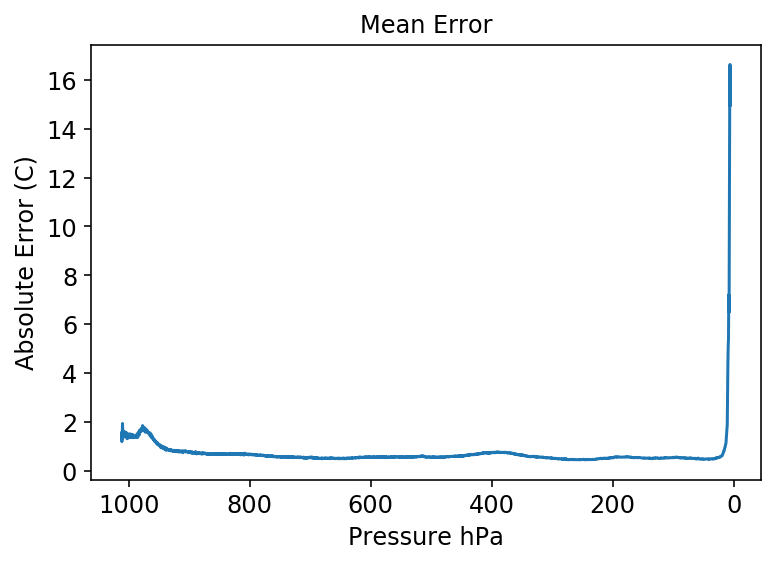

In [319]:
plt.plot(bins, mean_error)
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

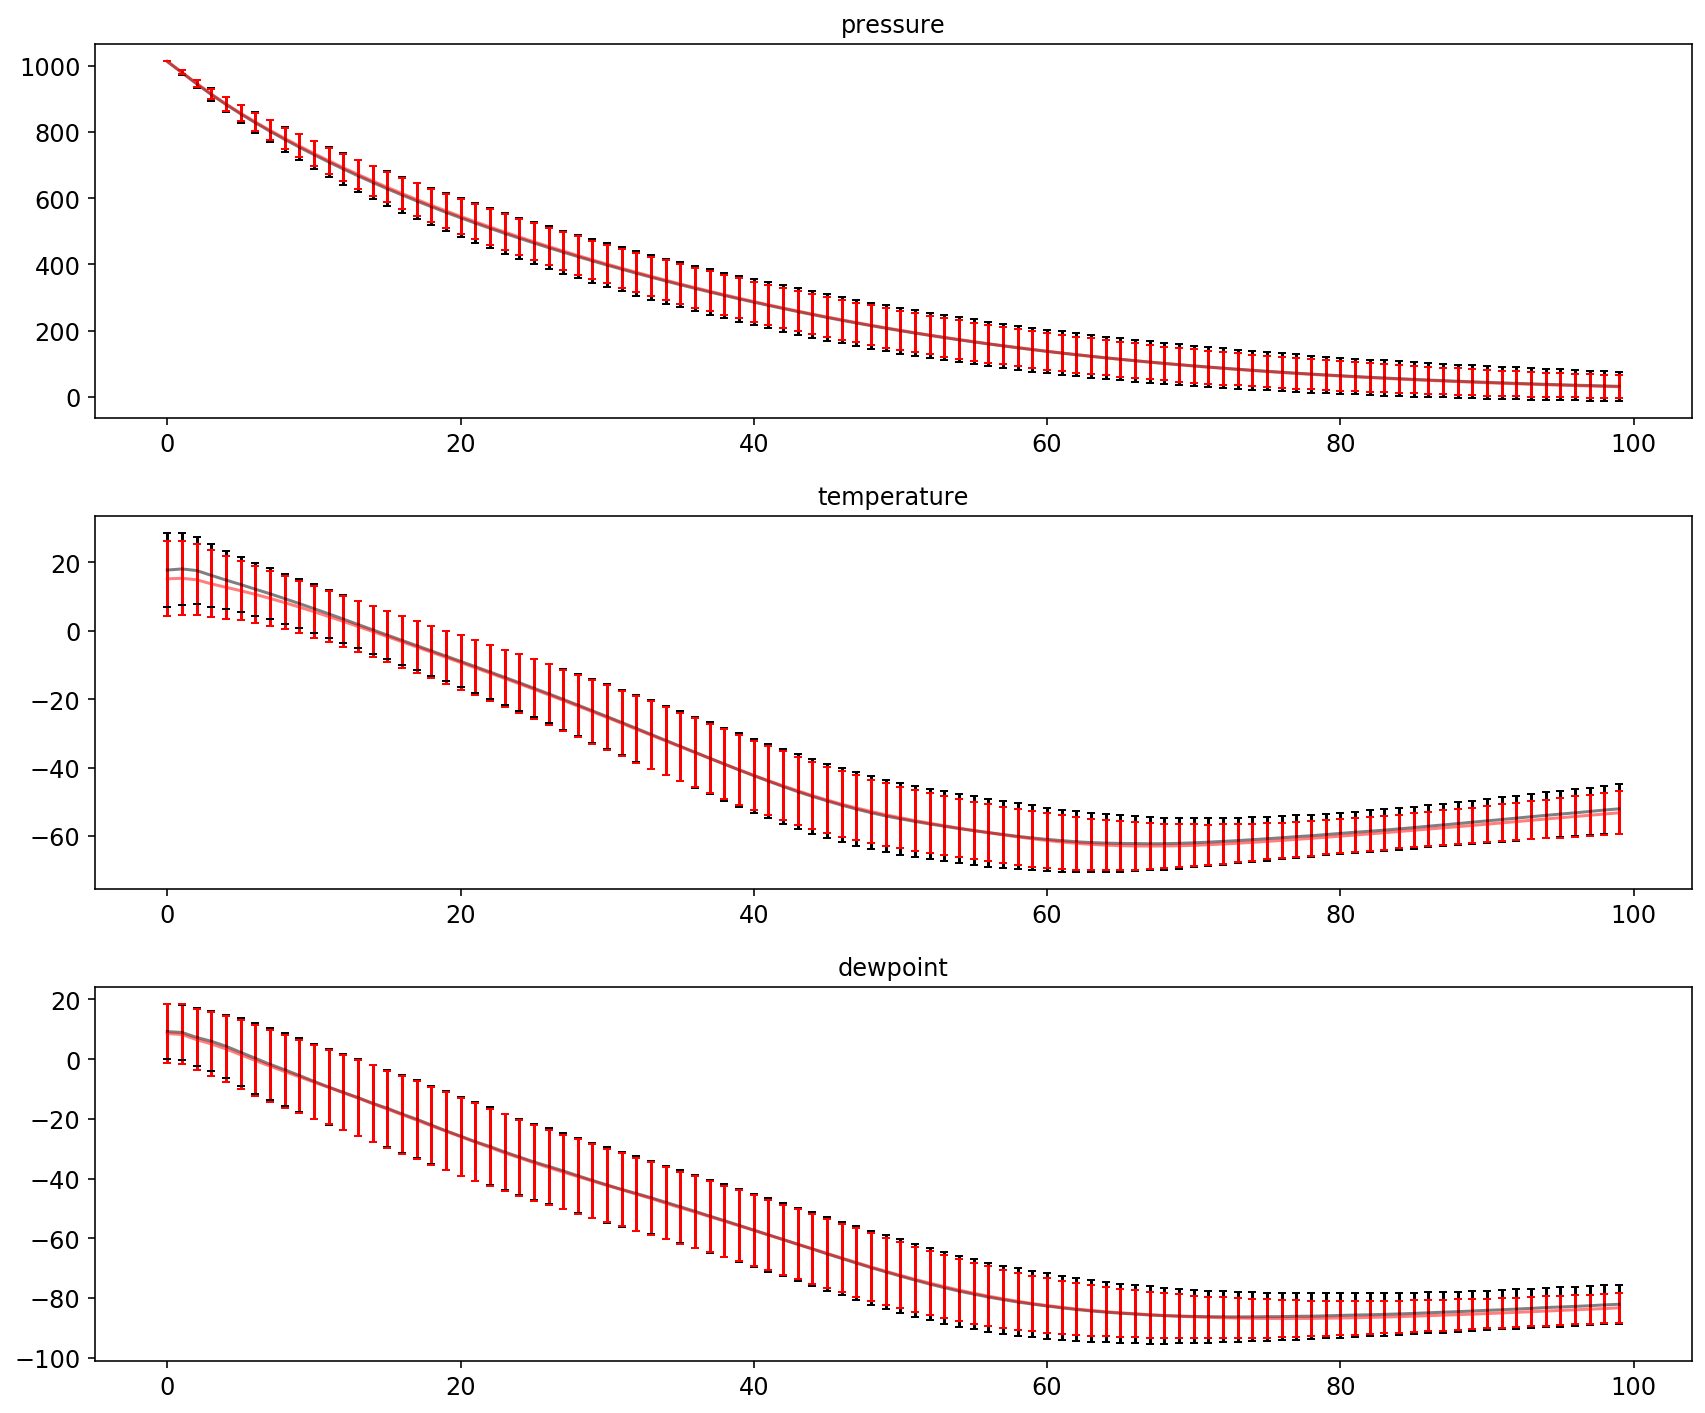

In [308]:
fig, axs = plt.subplots(len(input_dims), figsize=(12, 10))
axs = axs.ravel()
labels = ['pressure', 'temperature', 'dewpoint']
for dim in input_dims:

    mu = np.mean(Xtest[:,:,dim], axis=0)[::20]
    std = np.std(Xtest[:,:,dim], axis=0)[::20]

    axs[dim].plot(mu, 'k', alpha=0.5)
    axs[dim].errorbar(np.arange(mu.shape[0]), mu, std, color='k', linestyle='None', capsize=2);

    mu = np.mean(Xtrain[:,:,dim], axis=0)[::20]
    std = np.std(Xtrain[:,:,dim], axis=0)[::20]

    axs[dim].plot(mu, 'r', alpha=0.5, label='train')
    axs[dim].errorbar(np.arange(mu.shape[0]), mu, std, color='r', linestyle='None', capsize=2);
    axs[dim].set_title(labels[dim])
fig.tight_layout();               

### 2. Weighted Loss

- tf.keras.losses.logcosh performed well

In [6]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

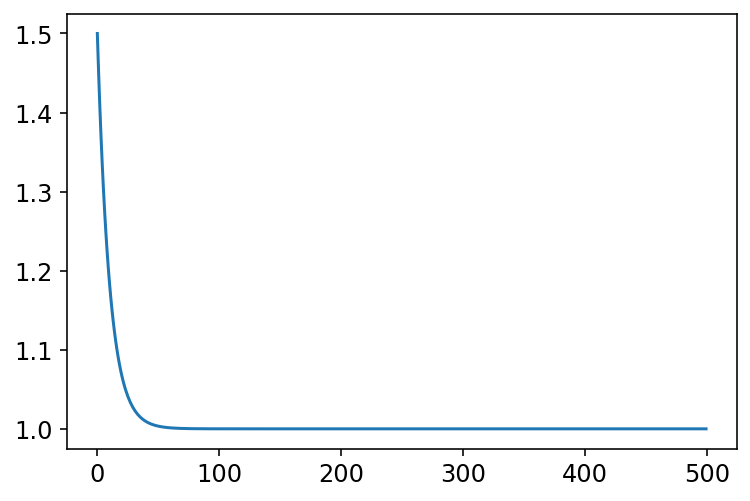

In [108]:
x = np.arange(2000)
y = lambda x: 0.5 * np.exp(-.1 * x) + 1
plt.plot(y(x)[:500]);

In [9]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]

In [56]:
def weighted_mean_squared_error(y_true, y_pred, scale):
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.squared_difference(y_pred, y_true)

    x = np.arange(diff.shape[1])
    y = lambda x: scale * np.exp(-.1 * x) + 1
    diff *= y(x)

    return K.mean(diff, axis=-1)

In [60]:
loss_l = []
mean_bin_error_l = []
bin_error_l = []
scales = np.linspace(0, 2, 10)

f = FloatProgress(min=0, max=(len(scales)))
display(f)

for scale in scales:
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 8, 16, 24], [(5, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
    nnet.train(Xtrain, Ttrain, 25, 128, method='adam', verbose=False, 
               learning_rate=0.001, validation=[Xtest, Ttest], 
               loss_f=[lambda y_true,y_pred: weighted_mean_squared_error(y_true, y_pred, scale=scale)])
    
    loss_l.append(nnet.history['val_loss'])
    
    mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)
    mean_bin_error_l.append(mean_error)
    bin_error_l.append(bins)
    f.value += 1

FloatProgress(value=0.0, max=10.0)

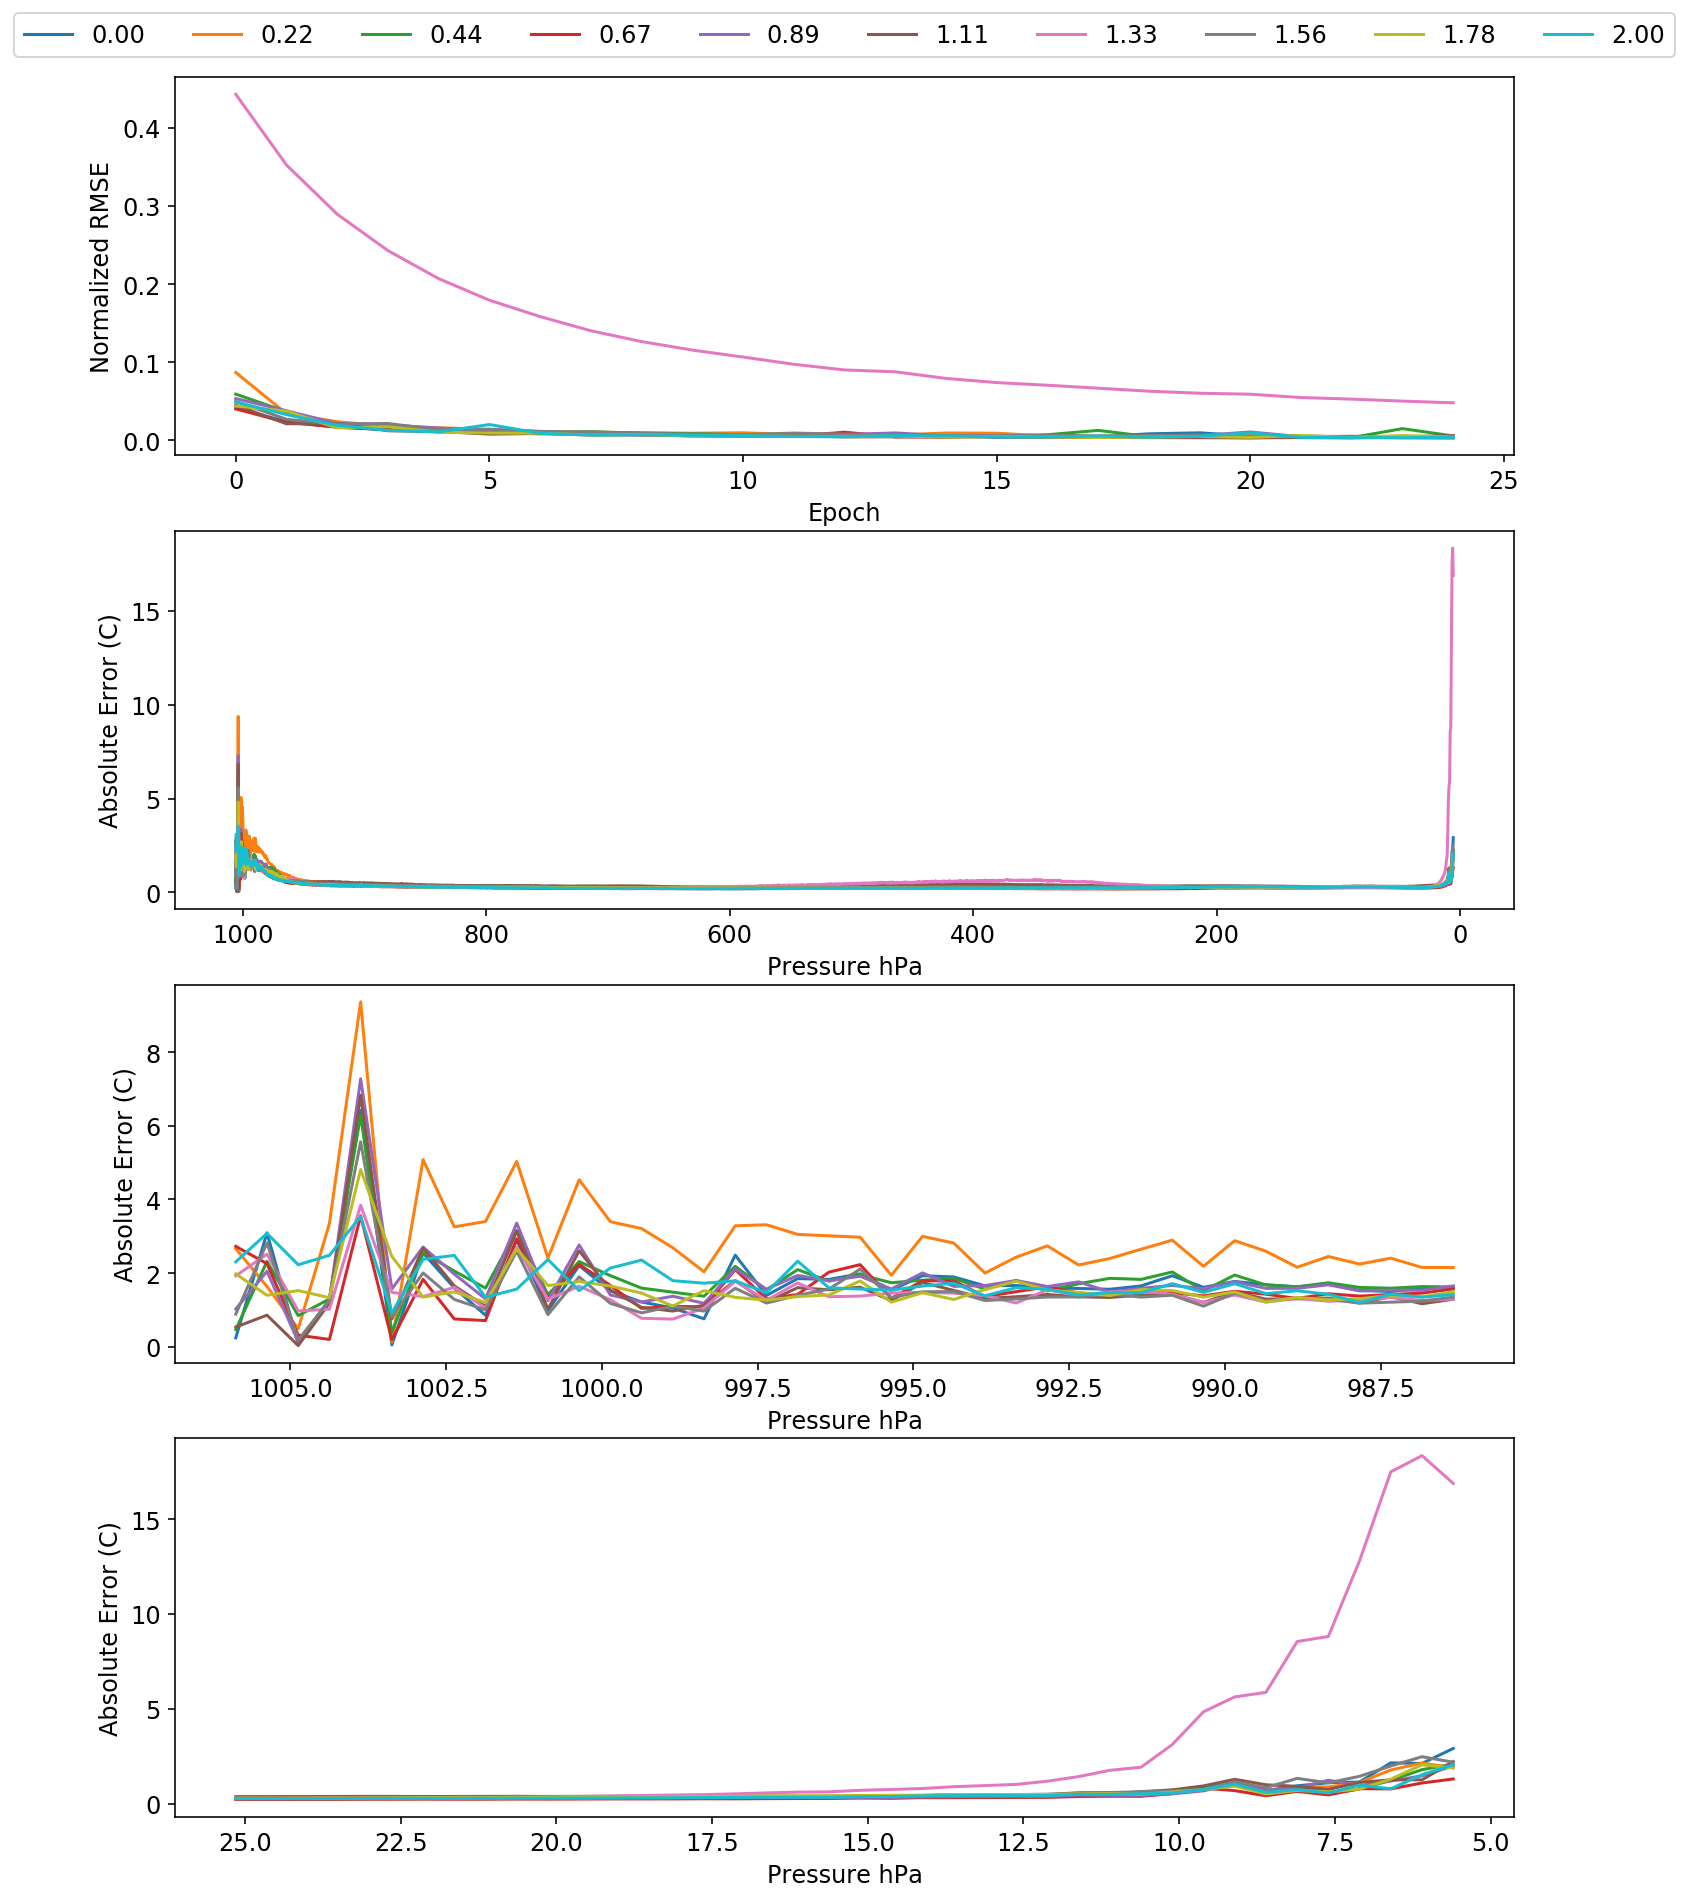

In [109]:
# results with y = lambda x: scale * np.exp(-.1 * x) + 1

fig, axs = plt.subplots(4, 1, figsize=(12, 16))
axs = axs.ravel()

for i in range(len(scales)):
    axs[0].plot(loss_l[i], label=f'{scales[i]:.2f}')
    axs[1].plot(bin_error_l[i], mean_bin_error_l[i])
    axs[2].plot(bin_error_l[i][-40:], mean_bin_error_l[i][-40:])
    axs[3].plot(bin_error_l[i][:40], mean_bin_error_l[i][:40])
    
axs[0].set_xlabel('Epoch');
axs[0].set_ylabel('Normalized RMSE')

for i in range(1, 4):
    axs[i].invert_xaxis()
    axs[i].set_xlabel('Pressure hPa')
    axs[i].set_ylabel('Absolute Error (C)');

axs.flatten()[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=10);

In [100]:
results = []
for i in range(len(scales)):
    results.append({'scale': f'{scales[i]:.2f}', 'min_loss': np.min(loss_l[i]),
                   'mean_abs_error': mean_bin_error_l[i].mean(), 'std_abs_error': mean_bin_error_l[i].std(),
                   'min_abs_error': mean_bin_error_l[i].min(), 'max_abs_error': mean_bin_error_l[i].max()})
    
df = pd.DataFrame(results)
df

scale  min_loss  mean_abs_error  std_abs_error  min_abs_error  max_abs_error
0  0.00  0.003461        0.354327       0.287162       0.047362       6.422755
1  0.22  0.004315        0.389349       0.455858       0.133602       9.371007
2  0.44  0.003548        0.368867       0.287249       0.248065       6.288447
3  0.67  0.002960        0.275261       0.237187       0.177842       3.556967
4  0.89  0.004547        0.370164       0.288375       0.135135       7.278817
5  1.11  0.003217        0.409723       0.241844       0.028464       6.835208
6  1.33  0.048040        0.450433       0.828484       0.210844      18.341692
7  1.56  0.004400        0.340693       0.242894       0.184265       5.569678
8  1.78  0.003495        0.312541       0.245943       0.209543       4.816937
9  2.00  0.003356        0.303577       0.256623       0.185399       3.535141

In [101]:
df.sort_values('max_abs_error')

scale  min_loss  mean_abs_error  std_abs_error  min_abs_error  max_abs_error
9  2.00  0.003356        0.303577       0.256623       0.185399       3.535141
3  0.67  0.002960        0.275261       0.237187       0.177842       3.556967
8  1.78  0.003495        0.312541       0.245943       0.209543       4.816937
7  1.56  0.004400        0.340693       0.242894       0.184265       5.569678
2  0.44  0.003548        0.368867       0.287249       0.248065       6.288447
0  0.00  0.003461        0.354327       0.287162       0.047362       6.422755
5  1.11  0.003217        0.409723       0.241844       0.028464       6.835208
4  0.89  0.004547        0.370164       0.288375       0.135135       7.278817
1  0.22  0.004315        0.389349       0.455858       0.133602       9.371007
6  1.33  0.048040        0.450433       0.828484       0.210844      18.341692

In [103]:
df.sort_values('mean_abs_error')

scale  min_loss  mean_abs_error  std_abs_error  min_abs_error  max_abs_error
3  0.67  0.002960        0.275261       0.237187       0.177842       3.556967
9  2.00  0.003356        0.303577       0.256623       0.185399       3.535141
8  1.78  0.003495        0.312541       0.245943       0.209543       4.816937
7  1.56  0.004400        0.340693       0.242894       0.184265       5.569678
0  0.00  0.003461        0.354327       0.287162       0.047362       6.422755
2  0.44  0.003548        0.368867       0.287249       0.248065       6.288447
4  0.89  0.004547        0.370164       0.288375       0.135135       7.278817
1  0.22  0.004315        0.389349       0.455858       0.133602       9.371007
5  1.11  0.003217        0.409723       0.241844       0.028464       6.835208
6  1.33  0.048040        0.450433       0.828484       0.210844      18.341692

In [48]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 8, 16, 24], [(5, 1)]*4,
                                   Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 25, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest], loss_f=weighted_mean_squared_error)

epoch: 0, loss: 0.19614
epoch: 5, loss: 0.01215
epoch: 10, loss: 0.00644
epoch: 15, loss: 0.00436
epoch: 20, loss: 0.00547
epoch: 24, loss: 0.00328
finished!


ConvolutionalAutoEncoder((2000, 3), [4, 8, 16, 24], [(5, 1), (5, 1), (5, 1), (5, 1)], 2000)
  Final objective value is 0.00328 in 363.0216 seconds.

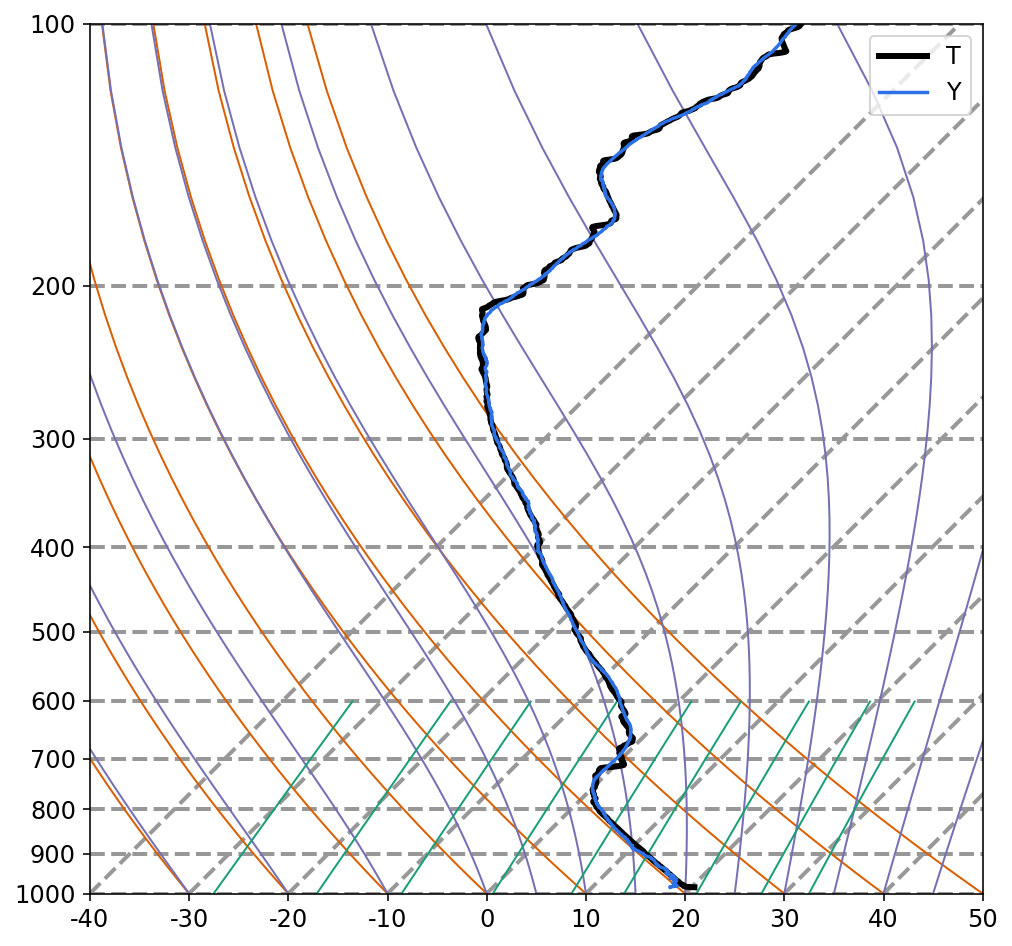

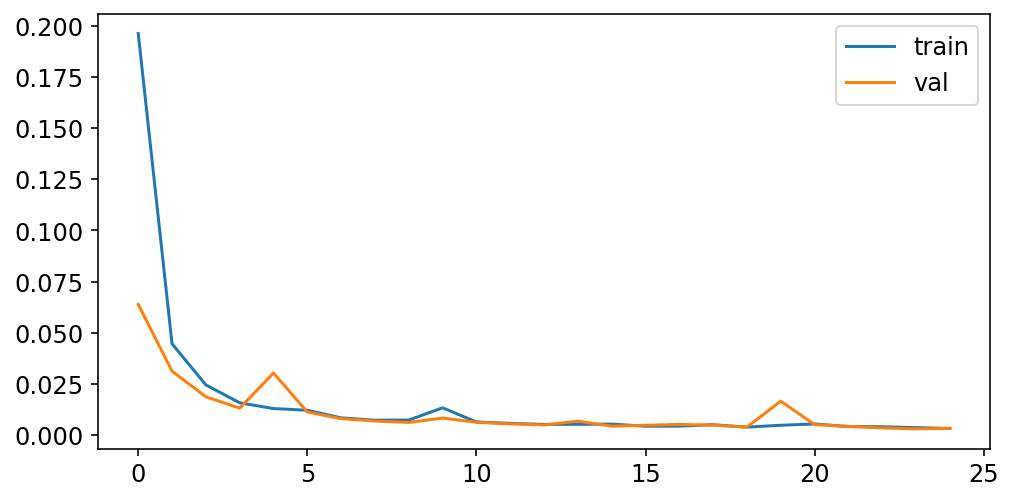

In [49]:
plot_results(nnet, Xtest, Ttest, index=22, loss=True)

In [51]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)

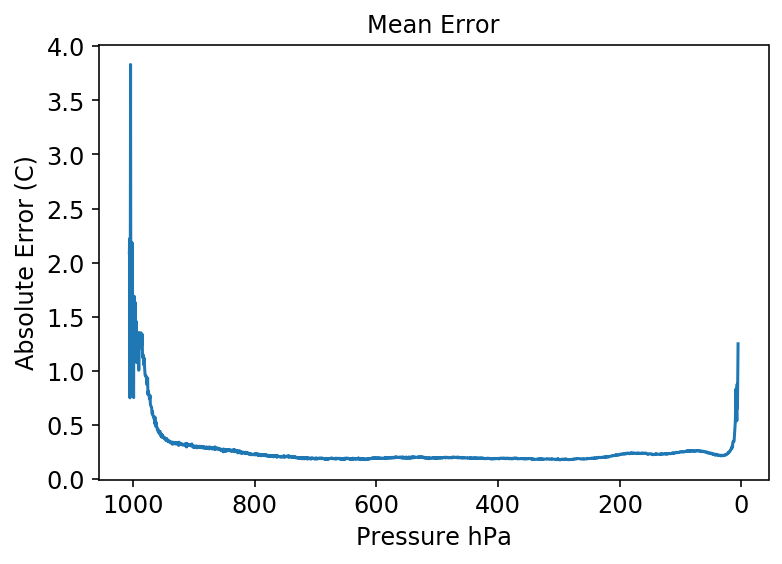

0.2630210982709843


In [46]:
plt.plot(bins, mean_error)
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();
print(mean_error.mean())

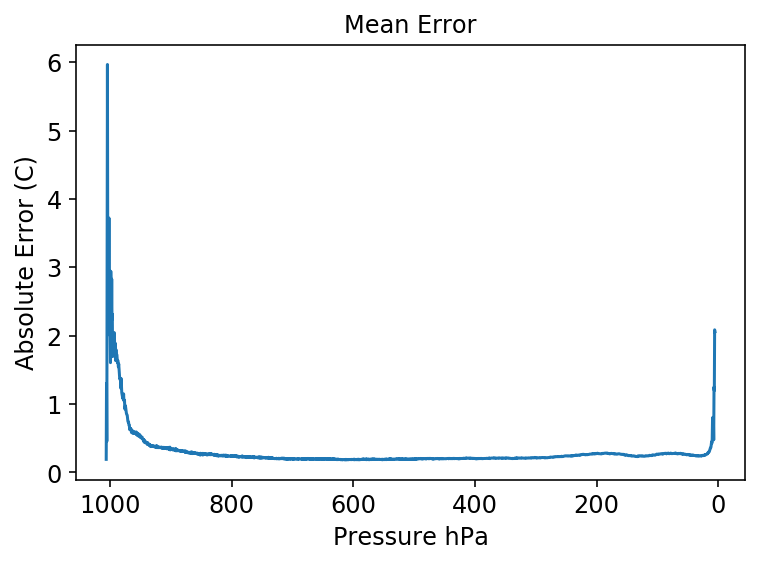

0.3003244155141011


In [52]:
plt.plot(bins, mean_error)
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();
print(mean_error.mean())

### 3. RTMA Surface

### 4. Independant Model Levels

In [281]:
steps = 4
step_size = profiles.shape[2] // steps
start = 0

step_mean_error, step_bins = [], []

f = FloatProgress(min=0, max=(steps))
display(f)

for i in range(steps):
    Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)
    
    input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

    Xtrain = np.swapaxes(Xtrain[:, input_dims, start:start+step_size], 1, 2)
    Ttrain = Ttrain[:, TEMPERATURE, start:start+step_size]

    Xtest = np.swapaxes(Xtest[:, input_dims, start:start+step_size], 1, 2)
    Ttest = Ttest[:, TEMPERATURE, start:start+step_size]

    nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(3, 1)]*4,
                                         Ttrain.shape[1], activation='relu')
    
    nnet.train(Xtrain, Ttrain, 10, 128, method='adam', verbose=False, 
               learning_rate=0.001, validation=[Xtest, Ttest])
    
    mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)
    
    step_mean_error.append(mean_error), step_bins.append(bins)
    
    start += step_size
    f.value += 1

FloatProgress(value=0.0, max=4.0)

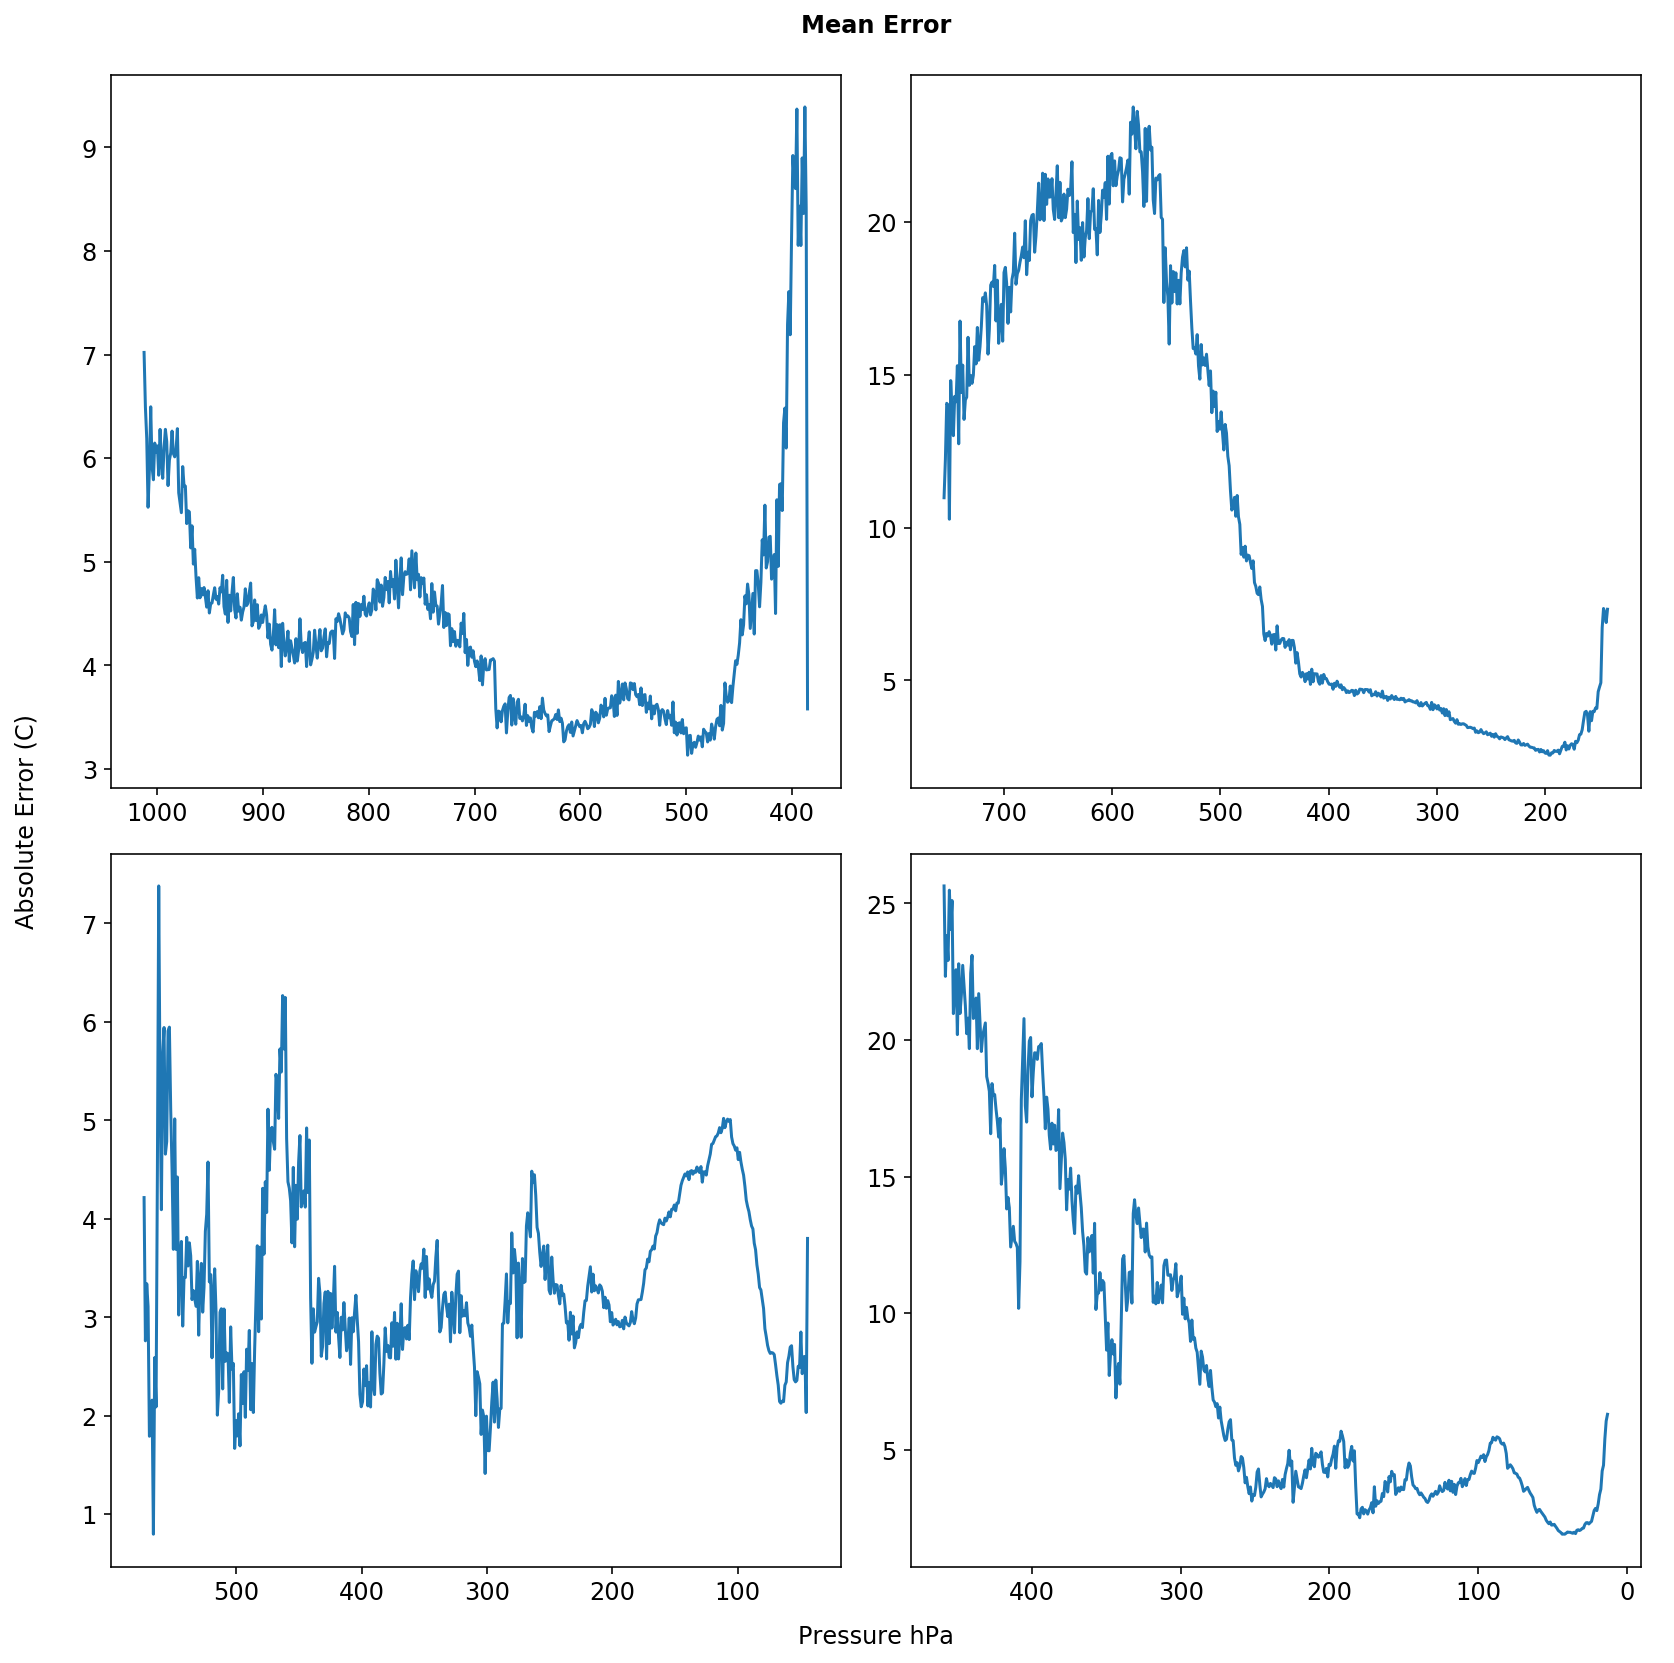

In [282]:
fig, axs = plt.subplots(steps//2, 2, figsize=(12, 12))
axs = axs.ravel()
for i in range(steps):
    axs[i].plot(step_bins[i], step_mean_error[i])
    axs[i].invert_xaxis()
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Pressure hPa', labelpad=10)
plt.ylabel('Absolute Error (C)', labelpad=10)
plt.title('Mean Error', y=1.02, fontweight='bold')

fig.tight_layout();

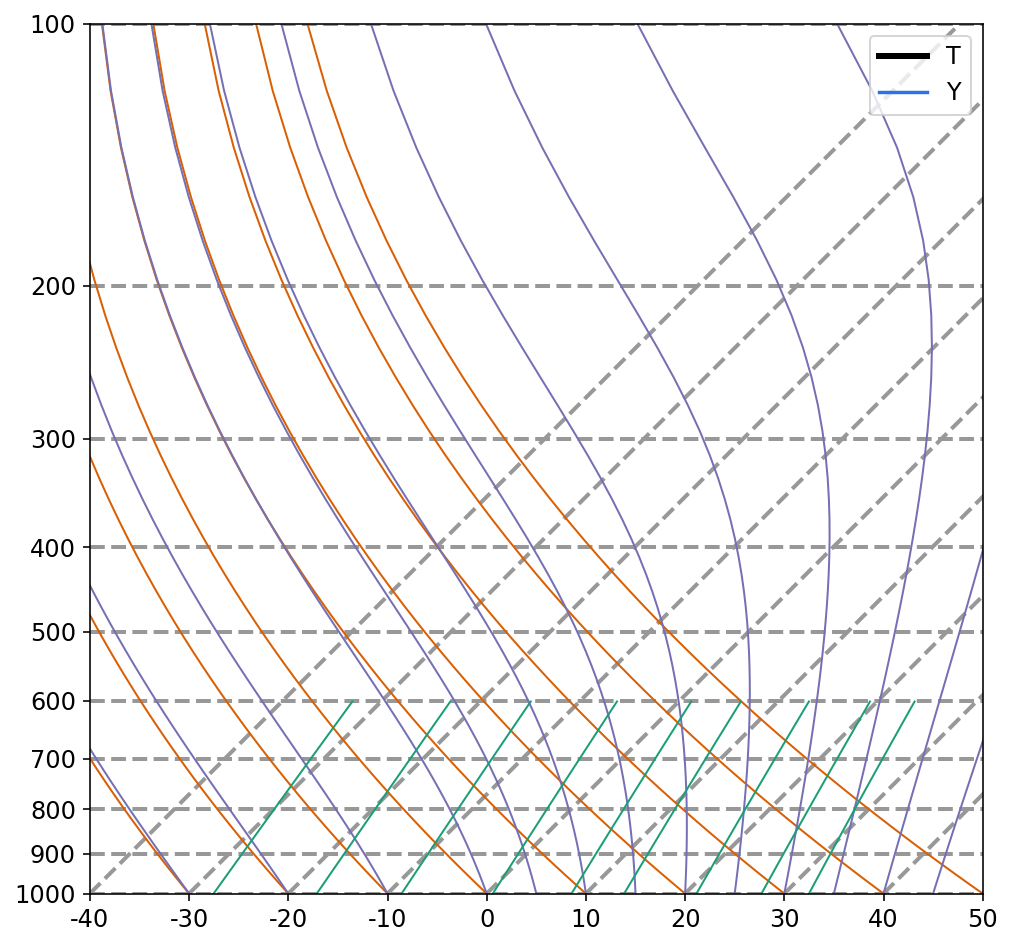

In [284]:
plot_results(nnet, Xtest, Ttest, 1, loss=False)